In [21]:
#this notebook reads the experimental and simulation data from a defined directory
#then a protocol of cross-validation on systems is performed on all data
#ultimately the results published in this study are obtained

In [22]:
#before executing this script:
#execute Supplementaries_GetParameters.ipynb with the following changes:
#comment and uncomment according to the instructions in 'save_single_min()' and 'main()'
#this should produce: 'SingleMinimization*' files needed at the end of this script

In [23]:
#main() computes reference force field errors
#main1() computes errors after fitting the force field without boundaries
#main2() computes errors after fitting the force field with boundaries
#main3() performs the cross-validation on systems over a range of hyperparameters
#main4() performs minimization over a range of hyperparameters

In [24]:
import concurrent.futures

In [25]:
def main():
    import bussilab
    from bussilab import wham
    import scipy
    from scipy.optimize import minimize
    import cudamat as cm
    import numpy as np
    import matplotlib.pyplot as plt
    import re
    kBT=0.6 #kBT in kcal/mol
    np.random.seed(1995)
    import os
    curr_dir=os.getcwd()

    #get experimental data
    print("Load experimental data")
    noe_exp=np.loadtxt("./data_loaded/GACC/exp_noes",usecols=(2,3))
    unoe_exp=np.loadtxt("./data_loaded/GACC/exp_unobs-noes",usecols=(2,3))
    sugar_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-sugar",usecols=(1,2))
    backbone1_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-1",usecols=(1,2))
    backbone2_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-2",usecols=(1,2))
    print(noe_exp.shape)
    print(unoe_exp.shape)
    print(sugar_exp.shape)
    print(backbone1_exp.shape)
    print(backbone2_exp.shape)
    print('There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.')
    
    def concatenate_simulation_data(files):
        result=None
        for t in files:
            if result is None:
                result=np.load(t)
                output=+result
            else:
                result=np.load(t)
                output=np.concatenate((output,result))

        return output

    def read_TLs(files):
        corr=[]
        for file in files:
            with open(file, "r") as f:
                for line in f:
                    nums=line.split()
                    if nums:
                        corr.append(np.array([float(i) for i in nums]))
        return np.array(corr)

    trajectoryNamesGACC=[]
    trajectoryNamesGAGA=[]
    trajectoryNamesUUCG=[]
    FFprefactorsGACC=[]
    FFprefactorsGAGA=[]
    FFprefactorsUUCG=[]

    with open("./data_loaded/coefficients.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            l=line.split()
            file=l[0]+".skip.npy"
            trajectoryNamesGACC.append(file)
            FFprefactorsGACC.append(np.array(np.array(l)[1:],dtype='float'))

    with open("./data_loaded/coefficients_TLs.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            if line.strip():
                l=line.split()
                file=l[0]+".npy"
                if 'gaga' in line:
                    FFprefactorsGAGA.append(np.array(l[1:],dtype='float'))
                if 'uucg' in line:
                    FFprefactorsUUCG.append(np.array(l[1:],dtype='float'))

    firstFF='nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping/'
    secondFF='nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping/'
    trajectoryNamesGAGA.append('./data_loaded/GAGA/'+firstFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesGAGA.append('./data_loaded/GAGA/'+secondFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesUUCG.append('./data_loaded/UUCG/'+firstFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesUUCG.append('./data_loaded/UUCG/'+secondFF+'gHBfix-parameters_state.rep0')

    #-------------------------------------------------------------------------------
    print('There are 14 simulations for GACC.')

    trajGACC=concatenate_simulation_data(['./data_loaded/GACC/' + x for x in trajectoryNamesGACC])
    backbone1=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_backbone-1",x) for x in trajectoryNamesGACC])
    backbone2=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_backbone-2",x) for x in trajectoryNamesGACC])
    sugar=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_sugar",x) for x in trajectoryNamesGACC])
    noe=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","noe",x) for x in trajectoryNamesGACC])
    unoe=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","unoe",x) for x in trajectoryNamesGACC])


    sugar=9.67*np.cos(sugar*np.pi/180)**2 - 2.03*np.cos(sugar*np.pi/180)
    backbone1=9.7*np.cos(backbone1*np.pi/180)**2 - 1.8*np.cos(backbone1*np.pi/180)
    backbone2=15.3*np.cos(backbone2*np.pi/180)**2 - 6.1*np.cos(backbone2*np.pi/180)+1.6
    noe=noe**-6
    unoe=unoe**-6
    print('There are 2 simulations per TL.')
    trajGAGA=read_TLs([x for x in trajectoryNamesGAGA])
    trajUUCG=read_TLs([x for x in trajectoryNamesUUCG])
    populationGAGA=trajGAGA[:,-1].reshape(-1,1)
    populationUUCG=trajUUCG[:,-1].reshape(-1,1)
    trajGAGA=trajGAGA[:,:12]
    trajUUCG=trajUUCG[:,:12]

    prune=False
    if prune==True:
        skip=5000
        print("Pruning data, skip")
        trajGACC=trajGACC[::skip,:]
        backbone1=backbone1[::skip,:]
        backbone2=backbone2[::skip,:]
        sugar=sugar[::skip,:]
        noe=noe[::skip,:]
        unoe=unoe[::skip,:]
        populationGAGA=populationGAGA[::skip,:]
        populationUUCG=populationUUCG[::skip,:]
        trajGAGA=trajGAGA[::skip,:]
        trajUUCG=trajUUCG[::skip,:]

    print("Check shape of arrays:")
    print(trajGACC.shape)
    print(backbone1.shape)
    print(backbone2.shape)
    print(sugar.shape)
    print(noe.shape)
    print(unoe.shape)
    print(populationGAGA.shape)
    print(populationUUCG.shape)
    print(trajGAGA.shape)
    print(trajUUCG.shape)
    
    def wham(bias_ff,frame_weight=None,traj_weight=None,T=1.0,maxit=1000,threshold=1e-40,verbose=False):
        """WHAM tool

           bias_ff[i,j] is the potential applied on frame i by Hamiltonian j
           Returns an array with the weight of each frame

        """
        import numpy as np
        # allow lists
        if not isinstance(bias_ff, (np.ndarray, np.generic) ):
            bias_ff=np.array(bias_ff)

        nframes=bias_ff.shape[0]
        ntraj=bias_ff.shape[1]

        # default values
        if frame_weight is None:
            frame_weight=np.ones(nframes)
        if traj_weight is None:
            traj_weight=np.ones(ntraj)

        assert(len(traj_weight)==ntraj)
        assert(len(frame_weight)==nframes)

        # do exponentials only once
        expv=np.exp((-bias_ff+np.min(bias_ff))/T)

        Z=np.ones(ntraj)
        Zold=np.copy(Z)

        if(verbose):
            print("WHAM: start")
        for it in range(maxit):
            weight=1.0/np.matmul(expv,traj_weight/Z)
            weight/=np.sum(weight*frame_weight)
            Z=np.matmul(frame_weight*weight,expv)
            Z/=np.sum(Z*traj_weight)
            eps=np.sum(np.log(Z/Zold)**2)
            Zold=Z
            if verbose:
                print("WHAM: iteration",it,"eps",eps)
            if(eps<threshold):
                break
        if(verbose):
            print("WHAM: end")
        return weight*frame_weight
    
    def calculate_TL_bias(Sequence,key):

        directories=["nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping", 
                     "nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping_bias-from-half-half",
                     "nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping_bias-from-one-zero",
                     "nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping"
                     ]

        collection_weights=[]
        for index,d in enumerate(directories):
            Metadweight=[]
            with open("./data_loaded/%s/%s/weights.rep0" %(Sequence,d) ,"r") as fp:
                for line in fp:
                    Metadweight.append(float(line))
            collection_weights.append(np.array(Metadweight))

        MetadPot1=np.concatenate((collection_weights[0],collection_weights[1]))
        MetadPot2=np.concatenate((collection_weights[2],collection_weights[3]))

        MetadPot=np.c_[ MetadPot1,MetadPot2 ] 
        MetadPot=kBT*np.log(MetadPot)

        if prune==True:
            MetadPot=MetadPot[::skip,:]

        if Sequence=='GAGA':
            if key == 'reference':
                #if nothing is subtracted one obtains the results for the AMBER FF
                bias=np.matmul(trajGAGA,np.array(FFprefactorsGAGA).T)+MetadPot
            #if one of the two FF is subtracted this improved FF becomes the new reference
            #we choose the second one since this is the proposed one
            if key == 'proposed':
                bias=np.matmul(trajGAGA,(FFprefactorsGAGA-FFprefactorsGAGA[1]).T)+MetadPot

        if Sequence=='UUCG':
            if key == 'reference':
                bias=np.matmul(trajUUCG,np.array(FFprefactorsUUCG).T)+MetadPot
            if key == 'proposed':
                bias=np.matmul(trajUUCG,(FFprefactorsUUCG-FFprefactorsUUCG[1]).T)+MetadPot

        del MetadPot1
        del MetadPot2
        del MetadPot

        return bias   

    #calculate all the weights
    weightsGACC=wham(np.matmul(trajGACC,np.transpose(FFprefactorsGACC-FFprefactorsGAGA[1])),verbose=False,threshold=1e-20,T=kBT)
    weightsGAGA=wham(calculate_TL_bias('GAGA','proposed'),verbose=False,threshold=1e-20,T=kBT)
    weightsUUCG=wham(calculate_TL_bias('UUCG','proposed'),verbose=False,threshold=1e-20,T=kBT)
    
    def activate_cuda(traj,weights, USE_CUDA):

        if USE_CUDA:
            # this is necessary to allow for CUDA operation
            cm.init(max_ones=traj.shape[0])
            cm_traj=cm.CUDAMatrix(traj.T)
            cm_weights=cm.CUDAMatrix(np.reshape(weights,(1,-1)))
            return cm_traj, cm_weights
        else:
            return traj,weights

    def compute_newweights(par,cm_traj,cm_weights,USE_CUDA):

        if USE_CUDA:
            cm_par=cm.CUDAMatrix(np.reshape(par,(1,-1)))
            cm_correction=cm.dot(cm_par,cm_traj)

            m=float(cm_correction.min(axis=1).asarray()[0,0])
            cm_correction.subtract(m)
            cm_correction.mult(-1.0)
            newweights=cm.exp(cm_correction)
            newweights.mult_by_row(cm_weights)
            newweights.mult(1.0/(cm.sum(newweights,axis=1).asarray()[0,0]))
            return newweights 
        else:
            correction=np.matmul(cm_traj,par)
            correction-=np.min(correction)
            newweights=np.exp(-correction)*cm_weights
            return newweights/np.sum(newweights)

    def function(par,obs,newweights,traj,cm_traj,USE_CUDA):

        gradient=True
        if USE_CUDA:
            if(isinstance(obs,cm.CUDAMatrix)):
                cm_obs=obs
            else:
                cm_obs=cm.CUDAMatrix(obs)
            if(isinstance(newweights,cm.CUDAMatrix)):
                cm_newweights=newweights
            else:
                cm_newweights=cm.CUDAMatrix(np.reshape(newweights,(1,-1)))
            av_obs=np.reshape(np.array(cm.dot(cm_newweights,cm_obs).asarray()),(-1))
        else:
            av_obs=np.reshape(np.array(np.matmul(newweights,obs)),(-1))

        if not gradient:
            return av_obs

        dav=np.zeros((len(par),obs.shape[1]))

        if USE_CUDA:
            cm_traj_weighted=cm.empty((traj.shape[1],traj.shape[0]))
            cm_traj_weighted.assign(cm_traj)
            cm_traj_weighted.mult_by_row(cm_newweights)
            av_traj=np.reshape(cm_traj_weighted.sum(axis=1).asarray(),(-1))
            dav=-cm.dot(cm_traj_weighted,cm_obs).asarray()
        else:
            weighted_traj=np.copy(traj)
            for ipar in range(len(par)):
                weighted_traj[:,ipar]=newweights*traj[:,ipar]
            av_traj=np.matmul(newweights,traj)
            for ipar in range(len(par)):
                for iobs in range(obs.shape[1]):
                    dav[ipar,iobs]=-np.sum(weighted_traj[:,ipar]*obs.T[iobs,:])

        for ipar in range(len(par)):
            for iobs in range(obs.shape[1]):
                dav[ipar,iobs]+=av_obs[iobs]*av_traj[ipar]

        return av_obs,dav
    
    def _logsum(ns):
        max = np.max(ns)
        ds = ns - max
        sumOfExp = np.exp(ds).sum()
        return max + np.log(sumOfExp)
    def _softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def func_and_grad(par,gradient=True,regularize=True,components=False):
        func=0.0
        chi2_native_GAGA=0.0
        chi2_native_UUCG=0.0
        chi2_noe=0.0
        chi2_unoe=0.0
        chi2_backbone1=0.0
        chi2_backbone2=0.0
        chi2_sugar=0.0

        if gradient:
            grad=np.zeros(len(par))
            grad_backbone1=np.zeros(len(par))
            grad_backbone2=np.zeros(len(par))
            grad_sugar=np.zeros(len(par))
            grad_noe=np.zeros(len(par))
            grad_unoe=np.zeros(len(par))
            grad_native_GAGA=np.zeros(len(par))
            grad_native_UUCG=np.zeros(len(par))



        USE_CUDA=True
        TLweight=(noe_exp.shape[0]+unoe_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0]+sugar_exp.shape[0])

        funcGAGA=0.0
        gradGAGA=np.zeros(len(par))
        if obs_weight[0] != 0:
            chi2_native_GAGA=0.0
            cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
            w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

            f=function(par,populationGAGA,w, trajGAGA,cm_traj, USE_CUDA)
            target_population=0.5
            diff=np.log(f[0]+eps)-np.log(target_population) 
            if(diff<.0):
                    chi2_native_GAGA+=diff**2
                    if gradient:
                        grad_native_GAGA+=np.matmul(f[1], 2*(np.log(f[0]+eps)-np.log(target_population))/(f[0]+eps))
            funcGAGA=obs_weight[0]*TLweight*chi2_native_GAGA
            if gradient:
                gradGAGA=obs_weight[0]*TLweight*grad_native_GAGA



        funcUUCG=0.0
        gradUUCG=np.zeros(len(par))
        if obs_weight[1] != 0:
            chi2_native_UUCG=0.0
            cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
            w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

            f=function(par,populationUUCG,w, trajUUCG,cm_traj, USE_CUDA)
            target_population=0.5
            diff=np.log(f[0]+eps)-np.log(target_population) 
            if(diff<.0):
                    chi2_native_UUCG+=diff**2
                    if gradient:
                        grad_native_UUCG+=np.matmul(f[1], 2*(np.log(f[0]+eps)-np.log(target_population))/(f[0]+eps))
            funcUUCG=obs_weight[1]*TLweight*chi2_native_UUCG
            if gradient:
                gradUUCG=obs_weight[1]*TLweight*grad_native_UUCG

        func+=prefactor*(funcGAGA+funcUUCG)
        if gradient:
            grad+=prefactor*(gradGAGA+gradUUCG)

        USE_CUDA=True
        cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
        w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

        if obs_weight[2] != 0:
            f=function(par,noe,w, trajGACC,cm_traj, USE_CUDA)
            chi2_noe=np.sum(((f[0]**(-1/6)-noe_exp[:,0])/noe_exp[:,1])**2)/noe_exp.shape[0]
            func+=obs_weight[2]*noe_exp.shape[0]*chi2_noe
            if gradient:
                grad_noe+=np.matmul(f[1],(2/noe_exp.shape[0] * ((f[0]**(-1/6)-noe_exp[:,0])/noe_exp[:,1]) * (-1/6) * f[0]**(-7/6))/noe_exp[:,1])
                grad+=obs_weight[2]*noe_exp.shape[0]*grad_noe

        if obs_weight[3] != 0:
            f=function(par,unoe,w, trajGACC,cm_traj, USE_CUDA)
            chi2_unoe=0.0
            for i in range(len(f[0])):
                diff=f[0][i]**(-1/6)-unoe_exp[i,0]
                if(diff<.0):
                    chi2_unoe+=(diff/unoe_exp[i,1])**2/unoe_exp.shape[0]
                    if gradient:
                        grad_unoe+=f[1][:,i]*2/unoe_exp.shape[0]* diff/unoe_exp[i,1]* (-1/6) * f[0][i]**(-7/6) /unoe_exp[i,1]
            func+=obs_weight[3]*unoe_exp.shape[0]*chi2_unoe
            if gradient:
                grad+=obs_weight[3]*unoe_exp.shape[0]*grad_unoe

        if obs_weight[4] != 0:
            f=function(par,backbone1,w, trajGACC,cm_traj, USE_CUDA)
            chi2_backbone1=np.sum(((f[0]-backbone1_exp[:,0])/backbone1_exp[:,1])**2)/backbone1_exp.shape[0]
            func+=obs_weight[4]*backbone1_exp.shape[0]*chi2_backbone1
            if gradient:
                grad_backbone1+=np.matmul(f[1],2/backbone1_exp.shape[0] * (f[0]-backbone1_exp[:,0])/backbone1_exp[:,1]/backbone1_exp[:,1])
                grad+=obs_weight[4]*backbone1_exp.shape[0]*grad_backbone1

        if obs_weight[5] != 0:
            f=function(par,backbone2,w, trajGACC,cm_traj, USE_CUDA)
            chi2_backbone2=np.sum(((f[0]-backbone2_exp[:,0])/backbone2_exp[:,1])**2)/backbone2_exp.shape[0]
            func+=obs_weight[5]*backbone2_exp.shape[0]*chi2_backbone2
            if gradient:
                grad_backbone2+=np.matmul(f[1],2/backbone2_exp.shape[0] * (f[0]-backbone2_exp[:,0])/backbone2_exp[:,1]/backbone2_exp[:,1])
                grad+=obs_weight[5]*backbone2_exp.shape[0]*grad_backbone2

        if obs_weight[6] != 0:
            f=function(par,sugar,w, trajGACC,cm_traj, USE_CUDA)
            chi2_sugar=np.sum(((f[0]-sugar_exp[:,0])/sugar_exp[:,1])**2)/sugar_exp.shape[0]
            func+=obs_weight[6]*sugar_exp.shape[0]*chi2_sugar
            if gradient:
                grad_sugar+=np.matmul(f[1],2/sugar_exp.shape[0] * (f[0]-sugar_exp[:,0])/sugar_exp[:,1]/sugar_exp[:,1])
                grad+=obs_weight[6]*sugar_exp.shape[0]*grad_sugar

        denominator=(obs_weight[0]*TLweight+obs_weight[1]*TLweight+obs_weight[2]*noe_exp.shape[0]+obs_weight[3]*unoe_exp.shape[0] + obs_weight[4]*backbone1_exp.shape[0]+ obs_weight[5]*backbone2_exp.shape[0]+obs_weight[6]*sugar_exp.shape[0])
        func/=denominator


        if gradient:
            grad/=denominator

        if regularize:
            if regularization == 'L1':
                regL1=alpha * np.sum(np.sqrt(eps+par**2))
                func+=regL1
                if gradient:
                    grad_regL1=(alpha*par)/(np.sqrt(eps+par**2))
                    grad+=grad_regL1


            if regularization == 'L2':
                regL2=alpha * np.sum(par**2)
                func+=regL2
                if gradient:
                    grad_regL2=2*alpha*par
                    grad+=grad_regL2

            if regularization == 'KishSize':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]


                kish=np.sum((new_weights[0]**2))
                kish_GAGA=np.sum((new_weights[1]**2))
                kish_UUCG=np.sum((new_weights[2]**2))

                kish_size=_logsum(np.array([kish,kish_GAGA,kish_UUCG]))
                chi2_kish=alpha*kish_size
                func+=chi2_kish

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=(elem**2)
                        c_a_i=t[index]
                        c_ave=np.matmul(new_weights[index],c_a_i)
                        grad_array[index]=-2*alpha*np.matmul(w_i,(c_a_i - c_ave)) 
                        grad_array[index]*=_softmax(np.array([kish,kish_GAGA,kish_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)

            if regularization == 'RelativeKishSize':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]

                Nf_list=[len(trajGACC),len(trajGAGA),len(trajUUCG)]
                kish=np.sum((eps+(new_weights[0]**2))/(eps+w_list[0]))/Nf_list[0]
                kish_GAGA=np.sum((eps+(new_weights[1]**2))/(eps+w_list[1]))/Nf_list[1]
                kish_UUCG=np.sum((eps+(new_weights[2]**2))/(eps+w_list[2]))/Nf_list[2]

                kish_size=_logsum(np.array([kish,kish_GAGA,kish_UUCG]))

                chi2_kish=alpha*kish_size
                func+=chi2_kish

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=eps+(elem**2)
                        w_i/=(eps+w_list[index])
                        c_a_i=t[index]

                        c_ave=np.matmul(new_weights[index],c_a_i)
                        grad_array[index]=np.matmul(w_i,(c_a_i - c_ave))
                        grad_array[index]*=-(2*alpha)
                        grad_array[index]/=Nf_list[index]

                        grad_array[index]*=_softmax(np.array([kish,kish_GAGA,kish_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)

            if regularization == 'RelativeEntropy':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]

                entropy=np.exp(np.sum(new_weights[0]*np.log((new_weights[0])/(w_list[0])+eps)))
                entropy_GAGA=np.exp(np.sum(new_weights[1]*np.log((new_weights[1])/(w_list[1])+eps)))
                entropy_UUCG=np.exp(np.sum(new_weights[2]*np.log((new_weights[2])/(w_list[2])+eps)))

                relative_entropy=_logsum(np.array([entropy,entropy_GAGA,entropy_UUCG]))

                chi2_entropy=alpha*relative_entropy
                func+=chi2_entropy

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=(elem) 
                        w_i_0=w_list[index]
                        c_a_i=t[index]
                        c_ave=np.matmul(eps+new_weights[index],c_a_i)
                        grad_array[index]=np.array([entropy,entropy_GAGA,entropy_UUCG])[index]

                        part1=-np.matmul(w_i*np.log((w_i/w_i_0)+eps),(c_a_i - c_ave))
                        part2=alpha*part1-alpha*np.matmul(w_i,(c_a_i - c_ave))
                        grad_array[index]*=part2

                        grad_array[index]*=_softmax(np.array([entropy,entropy_GAGA,entropy_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)


        if gradient:
            return float(func), np.array(grad)        

        if components:
            chi2_native_GAGA=float(obs_weight[0]*TLweight*chi2_native_GAGA)
            chi2_native_UUCG=float(obs_weight[1]*TLweight*chi2_native_UUCG)
            chi2_noe=float(obs_weight[2]*noe_exp.shape[0]*chi2_noe)
            chi2_unoe=float(obs_weight[3]*unoe_exp.shape[0]*chi2_unoe)
            chi2_backbone1=float(obs_weight[4]*backbone1_exp.shape[0]*chi2_backbone1)
            chi2_backbone2=float(obs_weight[4]*backbone2_exp.shape[0]*chi2_backbone2)
            chi2_sugar=float(obs_weight[5]*sugar_exp.shape[0]*chi2_sugar)

            return float(func), chi2_backbone1/denominator,chi2_backbone2/denominator,chi2_sugar/denominator,chi2_noe/denominator,chi2_unoe/denominator, chi2_native_GAGA/denominator,chi2_native_UUCG/denominator  

        return float(func)
    
    def save_t(data):
    
        chi2_col=data[1]
        chi2_ref_col=data[2]
        chi2_native_GAGA_col=data[3]
        chi2_native_UUCG_col=data[4]
        chi2_noes_col=data[5]
        chi2_unoes_col=data[6]
        chi2_sugar_col=data[7]
        chi2_backbone1_col=data[8]
        chi2_backbone2_col=data[9]
        populationGAGA_col=data[10]
        populationUUCG_col=data[11]

        temp=np.array([chi2_col,
    chi2_ref_col,
    chi2_native_GAGA_col,
    chi2_native_UUCG_col,
    chi2_noes_col,
    chi2_unoes_col,
    chi2_sugar_col,
    chi2_backbone1_col,
    chi2_backbone2_col,
    populationGAGA_col,
    populationUUCG_col],dtype='object')
        np.save("./data_produced/SystemValidation_errors_None_t.npy",temp)
        lambdas = np.asarray(data[0])
        np.save("./data_produced/SystemValidation_Lambdas_None.npy", lambdas)
    
    def save_v(data):
    
        chi2_col=data[1]
        chi2_ref_col=data[2]
        chi2_native_GAGA_col=data[3]
        chi2_native_UUCG_col=data[4]
        chi2_noes_col=data[5]
        chi2_unoes_col=data[6]
        chi2_sugar_col=data[7]
        chi2_backbone1_col=data[8]
        chi2_backbone2_col=data[9]
        populationGAGA_col=data[10]
        populationUUCG_col=data[11]

        temp=np.array([chi2_col,
    chi2_ref_col,
    chi2_native_GAGA_col,
    chi2_native_UUCG_col,
    chi2_noes_col,
    chi2_unoes_col,
    chi2_sugar_col,
    chi2_backbone1_col,
    chi2_backbone2_col,
    populationGAGA_col,
    populationUUCG_col],dtype='object')
        np.save("./data_produced/SystemValidation_errors_None_v.npy",temp)
    
    bounds=[]
    for i in range(12):
        bounds.append((-1.666666666666666,+1.666666666666666)) #bonds in kbT units set to -1 to 1 in kcal/mol (kbT*0.6=kcal/mol)

    eps=1e-30

    prefactor=1.0
    TLweight=(noe_exp.shape[0]+unoe_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0]+sugar_exp.shape[0])

    regularization='None'

    nsys=3
    chi2_ref_col_t=[]
    chi2_ref_col_v=[]
    for k in range(nsys):
        #GAGA
        if k==0:
            obs_weight=[0.0,1.0,1.0,1.0,1.0,1.0,1.0]
        #UUCG
        if k==1:
            obs_weight=[1.0,0.0,1.0,1.0,1.0,1.0,1.0]
        #GACC
        if k==2:
            obs_weight=[1.0,1.0,0.0,0.0,0.0,0.0,0.0]
        alpha=0.0
        regularization='None'
        ref_chi2=func_and_grad(np.zeros(12),gradient=False,regularize=False,components=False)
        print(ref_chi2)
        chi2_ref_col_t.append(ref_chi2)


        #GAGA
        if k==0:
            obs_weight=[1.0,0.0,0.0,0.0,0.0,0.0,0.0]
        #UUCG
        if k==1:
            obs_weight=[0.0,1.0,0.0,0.0,0.0,0.0,0.0]
        #GACC
        if k==2:
            obs_weight=[0.0,0.0,1.0,1.0,1.0,1.0,1.0]
        alpha=0.0
        regularization='None'
        ref_chi2=func_and_grad(np.zeros(12),gradient=False,regularize=False,components=False)
        print(ref_chi2)
        chi2_ref_col_v.append(ref_chi2)

    chi2_col_t=[]
    chi2_native_GAGA_col_t=[]
    chi2_native_UUCG_col_t=[]
    chi2_noes_col_t=[]
    chi2_unoes_col_t=[]
    chi2_sugar_col_t=[]
    chi2_backbone1_col_t=[]
    chi2_backbone2_col_t=[]
    chi2_col_v=[]
    chi2_native_GAGA_col_v=[]
    chi2_native_UUCG_col_v=[]
    chi2_noes_col_v=[]
    chi2_unoes_col_v=[]
    chi2_sugar_col_v=[]
    chi2_backbone1_col_v=[]
    chi2_backbone2_col_v=[]
    populationGAGA_col=[]
    populationUUCG_col=[]
    collection=[]
    print(regularization)

    print(alpha)

    for k in range(nsys):

        #GAGA
        if k==0:
            obs_weight=[0.0,1.0,1.0,1.0,1.0,1.0,1.0]
        #UUCG
        if k==1:
            obs_weight=[1.0,0.0,1.0,1.0,1.0,1.0,1.0]
        #GACC
        if k==2:
            obs_weight=[1.0,1.0,0.0,0.0,0.0,0.0,0.0]

        m=minimize(func_and_grad,x0=np.zeros(12),method='L-BFGS-B', jac=True)#,bounds=bounds)
        print(m.message, m.success)
        print(m.x)

        collection.append(list(m.x))

        t_chi2, t_chi2_backbone1,  t_chi2_backbone2, t_chi2_sugar, t_chi2_noes,  t_chi2_unoes, t_chi2_native_GAGA,t_chi2_native_UUCG  =func_and_grad(m.x,gradient=False,regularize=False,components=True)

        chi2_col_t.append(t_chi2)

        chi2_native_GAGA_col_t.append(t_chi2_native_GAGA)
        chi2_native_UUCG_col_t.append(t_chi2_native_UUCG)
        chi2_noes_col_t.append(t_chi2_noes)
        chi2_unoes_col_t.append(t_chi2_unoes)
        chi2_sugar_col_t.append(t_chi2_sugar)
        chi2_backbone1_col_t.append(t_chi2_backbone1)
        chi2_backbone2_col_t.append(t_chi2_backbone2)

        #GAGA
        if k==0:
            obs_weight=[1.0,0.0,0.0,0.0,0.0,0.0,0.0]
        #UUCG
        if k==1:
            obs_weight=[0.0,1.0,0.0,0.0,0.0,0.0,0.0]
        #GACC
        if k==2:
            obs_weight=[0.0,0.0,1.0,1.0,1.0,1.0,1.0]

        v_chi2, v_chi2_backbone1,  v_chi2_backbone2, v_chi2_sugar, v_chi2_noes,  v_chi2_unoes, v_chi2_native_GAGA,v_chi2_native_UUCG  =func_and_grad(m.x,gradient=False,regularize=False,components=True)

        chi2_col_v.append(v_chi2)

        chi2_native_GAGA_col_v.append(v_chi2_native_GAGA)
        chi2_native_UUCG_col_v.append(v_chi2_native_UUCG)
        chi2_noes_col_v.append(v_chi2_noes)
        chi2_unoes_col_v.append(v_chi2_unoes)
        chi2_sugar_col_v.append(v_chi2_sugar)
        chi2_backbone1_col_v.append(v_chi2_backbone1)
        chi2_backbone2_col_v.append(v_chi2_backbone2)

        par=m.x
        USE_CUDA=True

        cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
        new_weights=np.reshape(compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray(),(-1,))  
        print('native population in TL GAGA: ',np.matmul(new_weights,populationGAGA))

        cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
        new_weights=np.reshape(compute_newweights(par,cm_traj,cm_weights,True).asarray(),(-1,)) 
        print('native population in TL UUCG: ',np.matmul(new_weights,populationUUCG))

        populationGAGA_col.append(np.matmul(new_weights,populationGAGA))
        populationUUCG_col.append(np.matmul(new_weights,populationUUCG))


    save_list_t=[collection,
    chi2_col_t,
    chi2_ref_col_t,
    chi2_native_GAGA_col_t,
    chi2_native_UUCG_col_t,
    chi2_noes_col_t,
    chi2_unoes_col_t,
    chi2_sugar_col_t,
    chi2_backbone1_col_t,
    chi2_backbone2_col_t,
    populationGAGA_col,
    populationUUCG_col] 
    save_t(save_list_t)

    save_list_v=[collection,
    chi2_col_v,
    chi2_ref_col_v,
    chi2_native_GAGA_col_v,
    chi2_native_UUCG_col_v,
    chi2_noes_col_v,
    chi2_unoes_col_v,
    chi2_sugar_col_v,
    chi2_backbone1_col_v,
    chi2_backbone2_col_v,
    populationGAGA_col,
    populationUUCG_col] 
    save_v(save_list_v)

In [49]:
executor=concurrent.futures.ProcessPoolExecutor(max_workers=1)

In [ ]:
future_singlemin = executor.submit(main)

In [26]:
def main1():
    import scipy
    from scipy.optimize import minimize
    import cudamat as cm
    import numpy as np
    import matplotlib.pyplot as plt
    import re
    kBT=0.6 #kBT in kcal/mol
    np.random.seed(1995)
    import os
    curr_dir=os.getcwd()

    #get experimental data
    print("Load experimental data")
    noe_exp=np.loadtxt("./data_loaded/GACC/exp_noes",usecols=(2,3))
    unoe_exp=np.loadtxt("./data_loaded/GACC/exp_unobs-noes",usecols=(2,3))
    sugar_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-sugar",usecols=(1,2))
    backbone1_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-1",usecols=(1,2))
    backbone2_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-2",usecols=(1,2))
    print(noe_exp.shape)
    print(unoe_exp.shape)
    print(sugar_exp.shape)
    print(backbone1_exp.shape)
    print(backbone2_exp.shape)
    print('There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.')
    
    def concatenate_simulation_data(files):
        result=None
        for t in files:
            if result is None:
                result=np.load(t)
                output=+result
            else:
                result=np.load(t)
                output=np.concatenate((output,result))

        return output

    def read_TLs(files):
        corr=[]
        for file in files:
            with open(file, "r") as f:
                for line in f:
                    nums=line.split()
                    if nums:
                        corr.append(np.array([float(i) for i in nums]))
        return np.array(corr)

    trajectoryNamesGACC=[]
    trajectoryNamesGAGA=[]
    trajectoryNamesUUCG=[]
    FFprefactorsGACC=[]
    FFprefactorsGAGA=[]
    FFprefactorsUUCG=[]

    with open("./data_loaded/coefficients.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            l=line.split()
            file=l[0]+".skip.npy"
            trajectoryNamesGACC.append(file)
            FFprefactorsGACC.append(np.array(np.array(l)[1:],dtype='float'))

    with open("./data_loaded/coefficients_TLs.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            if line.strip():
                l=line.split()
                file=l[0]+".npy"
                if 'gaga' in line:
                    FFprefactorsGAGA.append(np.array(l[1:],dtype='float'))
                if 'uucg' in line:
                    FFprefactorsUUCG.append(np.array(l[1:],dtype='float'))

    firstFF='nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping/'
    secondFF='nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping/'
    trajectoryNamesGAGA.append('./data_loaded/GAGA/'+firstFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesGAGA.append('./data_loaded/GAGA/'+secondFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesUUCG.append('./data_loaded/UUCG/'+firstFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesUUCG.append('./data_loaded/UUCG/'+secondFF+'gHBfix-parameters_state.rep0')

    #-------------------------------------------------------------------------------
    print('There are 14 simulations for GACC.')

    trajGACC=concatenate_simulation_data(['./data_loaded/GACC/' + x for x in trajectoryNamesGACC])
    backbone1=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_backbone-1",x) for x in trajectoryNamesGACC])
    backbone2=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_backbone-2",x) for x in trajectoryNamesGACC])
    sugar=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_sugar",x) for x in trajectoryNamesGACC])
    noe=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","noe",x) for x in trajectoryNamesGACC])
    unoe=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","unoe",x) for x in trajectoryNamesGACC])


    sugar=9.67*np.cos(sugar*np.pi/180)**2 - 2.03*np.cos(sugar*np.pi/180)
    backbone1=9.7*np.cos(backbone1*np.pi/180)**2 - 1.8*np.cos(backbone1*np.pi/180)
    backbone2=15.3*np.cos(backbone2*np.pi/180)**2 - 6.1*np.cos(backbone2*np.pi/180)+1.6
    noe=noe**-6
    unoe=unoe**-6
    print('There are 2 simulations per TL.')
    trajGAGA=read_TLs([x for x in trajectoryNamesGAGA])
    trajUUCG=read_TLs([x for x in trajectoryNamesUUCG])
    populationGAGA=trajGAGA[:,-1].reshape(-1,1)
    populationUUCG=trajUUCG[:,-1].reshape(-1,1)
    trajGAGA=trajGAGA[:,:12]
    trajUUCG=trajUUCG[:,:12]

    prune=False
    if prune==True:
        skip=5000
        print("Pruning data, skip")
        trajGACC=trajGACC[::skip,:]
        backbone1=backbone1[::skip,:]
        backbone2=backbone2[::skip,:]
        sugar=sugar[::skip,:]
        noe=noe[::skip,:]
        unoe=unoe[::skip,:]
        populationGAGA=populationGAGA[::skip,:]
        populationUUCG=populationUUCG[::skip,:]
        trajGAGA=trajGAGA[::skip,:]
        trajUUCG=trajUUCG[::skip,:]

    print("Check shape of arrays:")
    print(trajGACC.shape)
    print(backbone1.shape)
    print(backbone2.shape)
    print(sugar.shape)
    print(noe.shape)
    print(unoe.shape)
    print(populationGAGA.shape)
    print(populationUUCG.shape)
    print(trajGAGA.shape)
    print(trajUUCG.shape)
    
    def wham(bias_ff,frame_weight=None,traj_weight=None,T=1.0,maxit=1000,threshold=1e-40,verbose=False):
        """WHAM tool

           bias_ff[i,j] is the potential applied on frame i by Hamiltonian j
           Returns an array with the weight of each frame

        """
        import numpy as np
        # allow lists
        if not isinstance(bias_ff, (np.ndarray, np.generic) ):
            bias_ff=np.array(bias_ff)

        nframes=bias_ff.shape[0]
        ntraj=bias_ff.shape[1]

        # default values
        if frame_weight is None:
            frame_weight=np.ones(nframes)
        if traj_weight is None:
            traj_weight=np.ones(ntraj)

        assert(len(traj_weight)==ntraj)
        assert(len(frame_weight)==nframes)

        # do exponentials only once
        expv=np.exp((-bias_ff+np.min(bias_ff))/T)

        Z=np.ones(ntraj)
        Zold=np.copy(Z)

        if(verbose):
            print("WHAM: start")
        for it in range(maxit):
            weight=1.0/np.matmul(expv,traj_weight/Z)
            weight/=np.sum(weight*frame_weight)
            Z=np.matmul(frame_weight*weight,expv)
            Z/=np.sum(Z*traj_weight)
            eps=np.sum(np.log(Z/Zold)**2)
            Zold=Z
            if verbose:
                print("WHAM: iteration",it,"eps",eps)
            if(eps<threshold):
                break
        if(verbose):
            print("WHAM: end")
        return weight*frame_weight
    
    def calculate_TL_bias(Sequence,key):

        directories=["nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping", 
                     "nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping_bias-from-half-half",
                     "nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping_bias-from-one-zero",
                     "nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping"
                     ]

        collection_weights=[]
        for index,d in enumerate(directories):
            Metadweight=[]
            with open("./data_loaded/%s/%s/weights.rep0" %(Sequence,d) ,"r") as fp:
                for line in fp:
                    Metadweight.append(float(line))
            collection_weights.append(np.array(Metadweight))

        #for full dataset
        MetadPot1=np.concatenate((collection_weights[0],collection_weights[1]))
        MetadPot2=np.concatenate((collection_weights[2],collection_weights[3]))

        MetadPot=np.c_[ MetadPot1,MetadPot2 ] 
        MetadPot=kBT*np.log(MetadPot)

        if prune==True:
            MetadPot=MetadPot[::skip,:]

        if Sequence=='GAGA':
            if key == 'reference':
                #if nothing is subtracted one obtains the results for the AMBER FF
                bias=np.matmul(trajGAGA,np.array(FFprefactorsGAGA).T)+MetadPot
            #if one of the two FF is subtracted this improved FF becomes the new reference
            #we choose the second one since this is the proposed one
            if key == 'proposed':
                bias=np.matmul(trajGAGA,(FFprefactorsGAGA-FFprefactorsGAGA[1]).T)+MetadPot

        if Sequence=='UUCG':
            if key == 'reference':
                bias=np.matmul(trajUUCG,np.array(FFprefactorsUUCG).T)+MetadPot
            if key == 'proposed':
                bias=np.matmul(trajUUCG,(FFprefactorsUUCG-FFprefactorsUUCG[1]).T)+MetadPot


        del MetadPot1
        del MetadPot2
        del MetadPot

        return bias   

    #calculate all the weights
    weightsGACC=wham(np.matmul(trajGACC,np.transpose(FFprefactorsGACC-FFprefactorsGAGA[1])),verbose=False,threshold=1e-20,T=kBT)
    weightsGAGA=wham(calculate_TL_bias('GAGA','proposed'),verbose=False,threshold=1e-20,T=kBT)
    weightsUUCG=wham(calculate_TL_bias('UUCG','proposed'),verbose=False,threshold=1e-20,T=kBT)
    
    
    def activate_cuda(traj,weights, USE_CUDA):

        if USE_CUDA:
            # this is necessary to allow for CUDA operation
            cm.init(max_ones=traj.shape[0])
            cm_traj=cm.CUDAMatrix(traj.T)
            cm_weights=cm.CUDAMatrix(np.reshape(weights,(1,-1)))
            return cm_traj, cm_weights
        else:
            return traj,weights

    def compute_newweights(par,cm_traj,cm_weights,USE_CUDA):

        if USE_CUDA:
            cm_par=cm.CUDAMatrix(np.reshape(par,(1,-1)))
            cm_correction=cm.dot(cm_par,cm_traj)

            m=float(cm_correction.min(axis=1).asarray()[0,0])
            cm_correction.subtract(m)
            cm_correction.mult(-1.0)
            newweights=cm.exp(cm_correction)
            newweights.mult_by_row(cm_weights)
            newweights.mult(1.0/(cm.sum(newweights,axis=1).asarray()[0,0]))
            return newweights 
        else:
            correction=np.matmul(cm_traj,par)
            correction-=np.min(correction)
            newweights=np.exp(-correction)*cm_weights
            return newweights/np.sum(newweights)

    def function(par,obs,newweights,traj,cm_traj,USE_CUDA):

        gradient=True
        if USE_CUDA:
            if(isinstance(obs,cm.CUDAMatrix)):
                cm_obs=obs
            else:
                cm_obs=cm.CUDAMatrix(obs)
            if(isinstance(newweights,cm.CUDAMatrix)):
                cm_newweights=newweights
            else:
                cm_newweights=cm.CUDAMatrix(np.reshape(newweights,(1,-1)))
            av_obs=np.reshape(np.array(cm.dot(cm_newweights,cm_obs).asarray()),(-1))
        else:
            av_obs=np.reshape(np.array(np.matmul(newweights,obs)),(-1))

        if not gradient:
            return av_obs

        dav=np.zeros((len(par),obs.shape[1]))

        if USE_CUDA:
            cm_traj_weighted=cm.empty((traj.shape[1],traj.shape[0]))
            cm_traj_weighted.assign(cm_traj)
            cm_traj_weighted.mult_by_row(cm_newweights)
            av_traj=np.reshape(cm_traj_weighted.sum(axis=1).asarray(),(-1))
            dav=-cm.dot(cm_traj_weighted,cm_obs).asarray()
        else:
            weighted_traj=np.copy(traj)
            for ipar in range(len(par)):
                weighted_traj[:,ipar]=newweights*traj[:,ipar]
            av_traj=np.matmul(newweights,traj)
            for ipar in range(len(par)):
                for iobs in range(obs.shape[1]):
                    dav[ipar,iobs]=-np.sum(weighted_traj[:,ipar]*obs.T[iobs,:])

        for ipar in range(len(par)):
            for iobs in range(obs.shape[1]):
                dav[ipar,iobs]+=av_obs[iobs]*av_traj[ipar]

        return av_obs,dav
    
    def _logsum(ns):
        max = np.max(ns)
        ds = ns - max
        sumOfExp = np.exp(ds).sum()
        return max + np.log(sumOfExp)
    def _softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def func_and_grad(par,gradient=True,regularize=True,components=False):
        func=0.0
        chi2_native_GAGA=0.0
        chi2_native_UUCG=0.0
        chi2_noe=0.0
        chi2_unoe=0.0
        chi2_backbone1=0.0
        chi2_backbone2=0.0
        chi2_sugar=0.0

        if gradient:
            grad=np.zeros(len(par))
            grad_backbone1=np.zeros(len(par))
            grad_backbone2=np.zeros(len(par))
            grad_sugar=np.zeros(len(par))
            grad_noe=np.zeros(len(par))
            grad_unoe=np.zeros(len(par))
            grad_native_GAGA=np.zeros(len(par))
            grad_native_UUCG=np.zeros(len(par))



        USE_CUDA=True
        TLweight=(noe_exp.shape[0]+unoe_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0]+sugar_exp.shape[0])

        funcGAGA=0.0
        gradGAGA=np.zeros(len(par))
        if obs_weight[0] != 0:
            chi2_native_GAGA=0.0
            cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
            w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

            f=function(par,populationGAGA,w, trajGAGA,cm_traj, USE_CUDA)
            target_population=0.5
            diff=np.log(f[0]+eps)-np.log(target_population) 
            if(diff<.0):
                    chi2_native_GAGA+=diff**2
                    if gradient:
                        grad_native_GAGA+=np.matmul(f[1], 2*(np.log(f[0]+eps)-np.log(target_population))/(f[0]+eps))
            funcGAGA=obs_weight[0]*TLweight*chi2_native_GAGA
            if gradient:
                gradGAGA=obs_weight[0]*TLweight*grad_native_GAGA



        funcUUCG=0.0
        gradUUCG=np.zeros(len(par))
        if obs_weight[1] != 0:
            chi2_native_UUCG=0.0
            cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
            w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

            f=function(par,populationUUCG,w, trajUUCG,cm_traj, USE_CUDA)
            target_population=0.5
            diff=np.log(f[0]+eps)-np.log(target_population) 
            if(diff<.0):
                    chi2_native_UUCG+=diff**2
                    if gradient:
                        grad_native_UUCG+=np.matmul(f[1], 2*(np.log(f[0]+eps)-np.log(target_population))/(f[0]+eps))
            funcUUCG=obs_weight[1]*TLweight*chi2_native_UUCG
            if gradient:
                gradUUCG=obs_weight[1]*TLweight*grad_native_UUCG

        func+=prefactor*(funcGAGA+funcUUCG)
        if gradient:
            grad+=prefactor*(gradGAGA+gradUUCG)

        USE_CUDA=True
        cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
        w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

        if obs_weight[2] != 0:
            f=function(par,noe,w, trajGACC,cm_traj, USE_CUDA)
            chi2_noe=np.sum(((f[0]**(-1/6)-noe_exp[:,0])/noe_exp[:,1])**2)/noe_exp.shape[0]
            func+=obs_weight[2]*noe_exp.shape[0]*chi2_noe
            if gradient:
                grad_noe+=np.matmul(f[1],(2/noe_exp.shape[0] * ((f[0]**(-1/6)-noe_exp[:,0])/noe_exp[:,1]) * (-1/6) * f[0]**(-7/6))/noe_exp[:,1])
                grad+=obs_weight[2]*noe_exp.shape[0]*grad_noe

        if obs_weight[3] != 0:
            f=function(par,unoe,w, trajGACC,cm_traj, USE_CUDA)
            chi2_unoe=0.0
            for i in range(len(f[0])):
                diff=f[0][i]**(-1/6)-unoe_exp[i,0]
                if(diff<.0):
                    chi2_unoe+=(diff/unoe_exp[i,1])**2/unoe_exp.shape[0]
                    if gradient:
                        grad_unoe+=f[1][:,i]*2/unoe_exp.shape[0]* diff/unoe_exp[i,1]* (-1/6) * f[0][i]**(-7/6) /unoe_exp[i,1]
            func+=obs_weight[3]*unoe_exp.shape[0]*chi2_unoe
            if gradient:
                grad+=obs_weight[3]*unoe_exp.shape[0]*grad_unoe

        if obs_weight[4] != 0:
            f=function(par,backbone1,w, trajGACC,cm_traj, USE_CUDA)
            chi2_backbone1=np.sum(((f[0]-backbone1_exp[:,0])/backbone1_exp[:,1])**2)/backbone1_exp.shape[0]
            func+=obs_weight[4]*backbone1_exp.shape[0]*chi2_backbone1
            if gradient:
                grad_backbone1+=np.matmul(f[1],2/backbone1_exp.shape[0] * (f[0]-backbone1_exp[:,0])/backbone1_exp[:,1]/backbone1_exp[:,1])
                grad+=obs_weight[4]*backbone1_exp.shape[0]*grad_backbone1

        if obs_weight[5] != 0:
            f=function(par,backbone2,w, trajGACC,cm_traj, USE_CUDA)
            chi2_backbone2=np.sum(((f[0]-backbone2_exp[:,0])/backbone2_exp[:,1])**2)/backbone2_exp.shape[0]
            func+=obs_weight[5]*backbone2_exp.shape[0]*chi2_backbone2
            if gradient:
                grad_backbone2+=np.matmul(f[1],2/backbone2_exp.shape[0] * (f[0]-backbone2_exp[:,0])/backbone2_exp[:,1]/backbone2_exp[:,1])
                grad+=obs_weight[5]*backbone2_exp.shape[0]*grad_backbone2

        if obs_weight[6] != 0:
            f=function(par,sugar,w, trajGACC,cm_traj, USE_CUDA)
            chi2_sugar=np.sum(((f[0]-sugar_exp[:,0])/sugar_exp[:,1])**2)/sugar_exp.shape[0]
            func+=obs_weight[6]*sugar_exp.shape[0]*chi2_sugar
            if gradient:
                grad_sugar+=np.matmul(f[1],2/sugar_exp.shape[0] * (f[0]-sugar_exp[:,0])/sugar_exp[:,1]/sugar_exp[:,1])
                grad+=obs_weight[6]*sugar_exp.shape[0]*grad_sugar

        denominator=(obs_weight[0]*TLweight+obs_weight[1]*TLweight+obs_weight[2]*noe_exp.shape[0]+obs_weight[3]*unoe_exp.shape[0] + obs_weight[4]*backbone1_exp.shape[0]+ obs_weight[5]*backbone2_exp.shape[0]+obs_weight[6]*sugar_exp.shape[0])
        func/=denominator


        if gradient:
            grad/=denominator

        if regularize:
            if regularization == 'L1':
                regL1=alpha * np.sum(np.sqrt(eps+par**2))
                func+=regL1
                if gradient:
                    grad_regL1=(alpha*par)/(np.sqrt(eps+par**2))
                    grad+=grad_regL1


            if regularization == 'L2':
                regL2=alpha * np.sum(par**2)
                func+=regL2
                if gradient:
                    grad_regL2=2*alpha*par
                    grad+=grad_regL2

            if regularization == 'KishSize':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]


                kish=np.sum((new_weights[0]**2))
                kish_GAGA=np.sum((new_weights[1]**2))
                kish_UUCG=np.sum((new_weights[2]**2))

                kish_size=_logsum(np.array([kish,kish_GAGA,kish_UUCG]))
                chi2_kish=alpha*kish_size
                func+=chi2_kish

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=(elem**2)
                        c_a_i=t[index]
                        c_ave=np.matmul(new_weights[index],c_a_i)
                        grad_array[index]=-2*alpha*np.matmul(w_i,(c_a_i - c_ave)) 
                        grad_array[index]*=_softmax(np.array([kish,kish_GAGA,kish_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)

            if regularization == 'RelativeKishSize':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]

                Nf_list=[len(trajGACC),len(trajGAGA),len(trajUUCG)]
                kish=np.sum((eps+(new_weights[0]**2))/(eps+w_list[0]))/Nf_list[0]
                kish_GAGA=np.sum((eps+(new_weights[1]**2))/(eps+w_list[1]))/Nf_list[1]
                kish_UUCG=np.sum((eps+(new_weights[2]**2))/(eps+w_list[2]))/Nf_list[2]

                kish_size=_logsum(np.array([kish,kish_GAGA,kish_UUCG]))

                chi2_kish=alpha*kish_size
                func+=chi2_kish

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=eps+(elem**2)
                        w_i/=(eps+w_list[index])
                        c_a_i=t[index]

                        c_ave=np.matmul(new_weights[index],c_a_i)
                        grad_array[index]=np.matmul(w_i,(c_a_i - c_ave))
                        grad_array[index]*=-(2*alpha)
                        grad_array[index]/=Nf_list[index]

                        grad_array[index]*=_softmax(np.array([kish,kish_GAGA,kish_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)

            if regularization == 'RelativeEntropy':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]

                entropy=np.exp(np.sum(new_weights[0]*np.log((new_weights[0])/(w_list[0])+eps)))
                entropy_GAGA=np.exp(np.sum(new_weights[1]*np.log((new_weights[1])/(w_list[1])+eps)))
                entropy_UUCG=np.exp(np.sum(new_weights[2]*np.log((new_weights[2])/(w_list[2])+eps)))

                relative_entropy=_logsum(np.array([entropy,entropy_GAGA,entropy_UUCG]))

                chi2_entropy=alpha*relative_entropy
                func+=chi2_entropy

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=(elem) 
                        w_i_0=w_list[index]
                        c_a_i=t[index]
                        c_ave=np.matmul(eps+new_weights[index],c_a_i)
                        grad_array[index]=np.array([entropy,entropy_GAGA,entropy_UUCG])[index]

                        part1=-np.matmul(w_i*np.log((w_i/w_i_0)+eps),(c_a_i - c_ave))
                        part2=alpha*part1-alpha*np.matmul(w_i,(c_a_i - c_ave))
                        grad_array[index]*=part2

                        grad_array[index]*=_softmax(np.array([entropy,entropy_GAGA,entropy_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)


        if gradient:
            return float(func), np.array(grad)        

        if components:
            chi2_native_GAGA=float(obs_weight[0]*TLweight*chi2_native_GAGA)
            chi2_native_UUCG=float(obs_weight[1]*TLweight*chi2_native_UUCG)
            chi2_noe=float(obs_weight[2]*noe_exp.shape[0]*chi2_noe)
            chi2_unoe=float(obs_weight[3]*unoe_exp.shape[0]*chi2_unoe)
            chi2_backbone1=float(obs_weight[4]*backbone1_exp.shape[0]*chi2_backbone1)
            chi2_backbone2=float(obs_weight[4]*backbone2_exp.shape[0]*chi2_backbone2)
            chi2_sugar=float(obs_weight[5]*sugar_exp.shape[0]*chi2_sugar)

            return float(func), chi2_backbone1/denominator,chi2_backbone2/denominator,chi2_sugar/denominator,chi2_noe/denominator,chi2_unoe/denominator, chi2_native_GAGA/denominator,chi2_native_UUCG/denominator  

        return float(func)
    
    def save_t(data):
    
        chi2_col=data[1]
        chi2_ref_col=data[2]
        chi2_native_GAGA_col=data[3]
        chi2_native_UUCG_col=data[4]
        chi2_noes_col=data[5]
        chi2_unoes_col=data[6]
        chi2_sugar_col=data[7]
        chi2_backbone1_col=data[8]
        chi2_backbone2_col=data[9]
        populationGAGA_col=data[10]
        populationUUCG_col=data[11]

        temp=np.array([chi2_col,
    chi2_ref_col,
    chi2_native_GAGA_col,
    chi2_native_UUCG_col,
    chi2_noes_col,
    chi2_unoes_col,
    chi2_sugar_col,
    chi2_backbone1_col,
    chi2_backbone2_col,
    populationGAGA_col,
    populationUUCG_col],dtype='object')
        np.save("./data_produced/SystemValidation_bounds_errors_None_t.npy",temp)
        lambdas = np.asarray(data[0])
        np.save("./data_produced/SystemValidation_bounds_Lambdas_None.npy", lambdas)
    
    def save_v(data):
    
        chi2_col=data[1]
        chi2_ref_col=data[2]
        chi2_native_GAGA_col=data[3]
        chi2_native_UUCG_col=data[4]
        chi2_noes_col=data[5]
        chi2_unoes_col=data[6]
        chi2_sugar_col=data[7]
        chi2_backbone1_col=data[8]
        chi2_backbone2_col=data[9]
        populationGAGA_col=data[10]
        populationUUCG_col=data[11]

        temp=np.array([chi2_col,
    chi2_ref_col,
    chi2_native_GAGA_col,
    chi2_native_UUCG_col,
    chi2_noes_col,
    chi2_unoes_col,
    chi2_sugar_col,
    chi2_backbone1_col,
    chi2_backbone2_col,
    populationGAGA_col,
    populationUUCG_col],dtype='object')
        np.save("./data_produced/SystemValidation_bounds_errors_None_v.npy",temp)
    
    #computing 'None' and 'orig'

    bounds=[]
    for i in range(12):
        bounds.append((-1.666666666666666,+1.666666666666666)) #bonds in kbT units set to -1 to 1 in kcal/mol (kbT*0.6=kcal/mol)

    eps=1e-30

    prefactor=1.0
    TLweight=(noe_exp.shape[0]+unoe_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0]+sugar_exp.shape[0])

    regularization='None'

    nsys=3
    chi2_ref_col_t=[]
    chi2_ref_col_v=[]
    for k in range(nsys):
        #GAGA
        if k==0:
            obs_weight=[0.0,1.0,1.0,1.0,1.0,1.0,1.0]
        #UUCG
        if k==1:
            obs_weight=[1.0,0.0,1.0,1.0,1.0,1.0,1.0]
        #GACC
        if k==2:
            obs_weight=[1.0,1.0,0.0,0.0,0.0,0.0,0.0]
        alpha=0.0
        regularization='None'
        ref_chi2=func_and_grad(np.zeros(12),gradient=False,regularize=False,components=False)
        print(ref_chi2)
        chi2_ref_col_t.append(ref_chi2)


        #GAGA
        if k==0:
            obs_weight=[1.0,0.0,0.0,0.0,0.0,0.0,0.0]
        #UUCG
        if k==1:
            obs_weight=[0.0,1.0,0.0,0.0,0.0,0.0,0.0]
        #GACC
        if k==2:
            obs_weight=[0.0,0.0,1.0,1.0,1.0,1.0,1.0]
        alpha=0.0
        regularization='None'
        ref_chi2=func_and_grad(np.zeros(12),gradient=False,regularize=False,components=False)
        print(ref_chi2)
        chi2_ref_col_v.append(ref_chi2)

    chi2_col_t=[]
    chi2_native_GAGA_col_t=[]
    chi2_native_UUCG_col_t=[]
    chi2_noes_col_t=[]
    chi2_unoes_col_t=[]
    chi2_sugar_col_t=[]
    chi2_backbone1_col_t=[]
    chi2_backbone2_col_t=[]
    chi2_col_v=[]
    chi2_native_GAGA_col_v=[]
    chi2_native_UUCG_col_v=[]
    chi2_noes_col_v=[]
    chi2_unoes_col_v=[]
    chi2_sugar_col_v=[]
    chi2_backbone1_col_v=[]
    chi2_backbone2_col_v=[]
    populationGAGA_col=[]
    populationUUCG_col=[]
    collection=[]
    print(regularization)

    print(alpha)

    for k in range(nsys):

        #GAGA
        if k==0:
            obs_weight=[0.0,1.0,1.0,1.0,1.0,1.0,1.0]
        #UUCG
        if k==1:
            obs_weight=[1.0,0.0,1.0,1.0,1.0,1.0,1.0]
        #GACC
        if k==2:
            obs_weight=[1.0,1.0,0.0,0.0,0.0,0.0,0.0]

        m=minimize(func_and_grad,x0=np.zeros(12),method='L-BFGS-B', jac=True,bounds=bounds)
        print(m.message, m.success)
        print(m.x)

        collection.append(list(m.x))

        t_chi2, t_chi2_backbone1,  t_chi2_backbone2, t_chi2_sugar, t_chi2_noes,  t_chi2_unoes, t_chi2_native_GAGA,t_chi2_native_UUCG  =func_and_grad(m.x,gradient=False,regularize=False,components=True)

        chi2_col_t.append(t_chi2)

        chi2_native_GAGA_col_t.append(t_chi2_native_GAGA)
        chi2_native_UUCG_col_t.append(t_chi2_native_UUCG)
        chi2_noes_col_t.append(t_chi2_noes)
        chi2_unoes_col_t.append(t_chi2_unoes)
        chi2_sugar_col_t.append(t_chi2_sugar)
        chi2_backbone1_col_t.append(t_chi2_backbone1)
        chi2_backbone2_col_t.append(t_chi2_backbone2)

        #GAGA
        if k==0:
            obs_weight=[1.0,0.0,0.0,0.0,0.0,0.0,0.0]
        #UUCG
        if k==1:
            obs_weight=[0.0,1.0,0.0,0.0,0.0,0.0,0.0]
        #GACC
        if k==2:
            obs_weight=[0.0,0.0,1.0,1.0,1.0,1.0,1.0]

        v_chi2, v_chi2_backbone1,  v_chi2_backbone2, v_chi2_sugar, v_chi2_noes,  v_chi2_unoes, v_chi2_native_GAGA,v_chi2_native_UUCG  =func_and_grad(m.x,gradient=False,regularize=False,components=True)

        chi2_col_v.append(v_chi2)

        chi2_native_GAGA_col_v.append(v_chi2_native_GAGA)
        chi2_native_UUCG_col_v.append(v_chi2_native_UUCG)
        chi2_noes_col_v.append(v_chi2_noes)
        chi2_unoes_col_v.append(v_chi2_unoes)
        chi2_sugar_col_v.append(v_chi2_sugar)
        chi2_backbone1_col_v.append(v_chi2_backbone1)
        chi2_backbone2_col_v.append(v_chi2_backbone2)

        par=m.x
        USE_CUDA=True

        cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
        new_weights=np.reshape(compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray(),(-1,))  
        print('native population in TL GAGA: ',np.matmul(new_weights,populationGAGA))

        cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
        new_weights=np.reshape(compute_newweights(par,cm_traj,cm_weights,True).asarray(),(-1,)) 
        print('native population in TL UUCG: ',np.matmul(new_weights,populationUUCG))

        populationGAGA_col.append(np.matmul(new_weights,populationGAGA))
        populationUUCG_col.append(np.matmul(new_weights,populationUUCG))


    save_list_t=[collection,
    chi2_col_t,
    chi2_ref_col_t,
    chi2_native_GAGA_col_t,
    chi2_native_UUCG_col_t,
    chi2_noes_col_t,
    chi2_unoes_col_t,
    chi2_sugar_col_t,
    chi2_backbone1_col_t,
    chi2_backbone2_col_t,
    populationGAGA_col,
    populationUUCG_col] 
    save_t(save_list_t)

    save_list_v=[collection,
    chi2_col_v,
    chi2_ref_col_v,
    chi2_native_GAGA_col_v,
    chi2_native_UUCG_col_v,
    chi2_noes_col_v,
    chi2_unoes_col_v,
    chi2_sugar_col_v,
    chi2_backbone1_col_v,
    chi2_backbone2_col_v,
    populationGAGA_col,
    populationUUCG_col] 
    save_v(save_list_v)

In [ ]:
executor=concurrent.futures.ProcessPoolExecutor(max_workers=1)

In [ ]:
future_singlemin_bounds = executor.submit(main1)

In [27]:
def main2():
    import scipy
    from scipy.optimize import minimize
    import cudamat as cm
    import numpy as np
    import matplotlib.pyplot as plt
    import re
    kBT=0.6 #kBT in kcal/mol
    np.random.seed(1995)
    import os
    curr_dir=os.getcwd()

    #get experimental data
    print("Load experimental data")
    noe_exp=np.loadtxt("./data_loaded/GACC/exp_noes",usecols=(2,3))
    unoe_exp=np.loadtxt("./data_loaded/GACC/exp_unobs-noes",usecols=(2,3))
    sugar_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-sugar",usecols=(1,2))
    backbone1_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-1",usecols=(1,2))
    backbone2_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-2",usecols=(1,2))
    print(noe_exp.shape)
    print(unoe_exp.shape)
    print(sugar_exp.shape)
    print(backbone1_exp.shape)
    print(backbone2_exp.shape)
    print('There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.')
    
    def concatenate_simulation_data(files):
        result=None
        for t in files:
            if result is None:
                result=np.load(t)
                output=+result
            else:
                result=np.load(t)
                output=np.concatenate((output,result))

        return output

    def read_TLs(files):
        corr=[]
        for file in files:
            with open(file, "r") as f:
                for line in f:
                    nums=line.split()
                    if nums:
                        corr.append(np.array([float(i) for i in nums]))
        return np.array(corr)

    trajectoryNamesGACC=[]
    trajectoryNamesGAGA=[]
    trajectoryNamesUUCG=[]
    FFprefactorsGACC=[]
    FFprefactorsGAGA=[]
    FFprefactorsUUCG=[]

    with open("./data_loaded/coefficients.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            l=line.split()
            file=l[0]+".skip.npy"
            trajectoryNamesGACC.append(file)
            FFprefactorsGACC.append(np.array(np.array(l)[1:],dtype='float'))

    with open("./data_loaded/coefficients_TLs.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            if line.strip():
                l=line.split()
                file=l[0]+".npy"
                if 'gaga' in line:
                    FFprefactorsGAGA.append(np.array(l[1:],dtype='float'))
                if 'uucg' in line:
                    FFprefactorsUUCG.append(np.array(l[1:],dtype='float'))

    firstFF='nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping/'
    secondFF='nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping/'
    trajectoryNamesGAGA.append('./data_loaded/GAGA/'+firstFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesGAGA.append('./data_loaded/GAGA/'+secondFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesUUCG.append('./data_loaded/UUCG/'+firstFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesUUCG.append('./data_loaded/UUCG/'+secondFF+'gHBfix-parameters_state.rep0')

    #-------------------------------------------------------------------------------
    print('There are 14 simulations for GACC.')

    trajGACC=concatenate_simulation_data(['./data_loaded/GACC/' + x for x in trajectoryNamesGACC])
    backbone1=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_backbone-1",x) for x in trajectoryNamesGACC])
    backbone2=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_backbone-2",x) for x in trajectoryNamesGACC])
    sugar=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_sugar",x) for x in trajectoryNamesGACC])
    noe=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","noe",x) for x in trajectoryNamesGACC])
    unoe=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","unoe",x) for x in trajectoryNamesGACC])


    sugar=9.67*np.cos(sugar*np.pi/180)**2 - 2.03*np.cos(sugar*np.pi/180)
    backbone1=9.7*np.cos(backbone1*np.pi/180)**2 - 1.8*np.cos(backbone1*np.pi/180)
    backbone2=15.3*np.cos(backbone2*np.pi/180)**2 - 6.1*np.cos(backbone2*np.pi/180)+1.6
    noe=noe**-6
    unoe=unoe**-6
    print('There are 2 simulations per TL.')
    trajGAGA=read_TLs([x for x in trajectoryNamesGAGA])
    trajUUCG=read_TLs([x for x in trajectoryNamesUUCG])
    populationGAGA=trajGAGA[:,-1].reshape(-1,1)
    populationUUCG=trajUUCG[:,-1].reshape(-1,1)
    trajGAGA=trajGAGA[:,:12]
    trajUUCG=trajUUCG[:,:12]

    prune=False
    if prune==True:
        skip=5000
        print("Pruning data, skip")
        trajGACC=trajGACC[::skip,:]
        backbone1=backbone1[::skip,:]
        backbone2=backbone2[::skip,:]
        sugar=sugar[::skip,:]
        noe=noe[::skip,:]
        unoe=unoe[::skip,:]
        populationGAGA=populationGAGA[::skip,:]
        populationUUCG=populationUUCG[::skip,:]
        trajGAGA=trajGAGA[::skip,:]
        trajUUCG=trajUUCG[::skip,:]

    print("Check shape of arrays:")
    print(trajGACC.shape)
    print(backbone1.shape)
    print(backbone2.shape)
    print(sugar.shape)
    print(noe.shape)
    print(unoe.shape)
    print(populationGAGA.shape)
    print(populationUUCG.shape)
    print(trajGAGA.shape)
    print(trajUUCG.shape)
    
    def wham(bias_ff,frame_weight=None,traj_weight=None,T=1.0,maxit=1000,threshold=1e-40,verbose=False):
        """WHAM tool

           bias_ff[i,j] is the potential applied on frame i by Hamiltonian j
           Returns an array with the weight of each frame

        """
        import numpy as np
        # allow lists
        if not isinstance(bias_ff, (np.ndarray, np.generic) ):
            bias_ff=np.array(bias_ff)

        nframes=bias_ff.shape[0]
        ntraj=bias_ff.shape[1]

        # default values
        if frame_weight is None:
            frame_weight=np.ones(nframes)
        if traj_weight is None:
            traj_weight=np.ones(ntraj)

        assert(len(traj_weight)==ntraj)
        assert(len(frame_weight)==nframes)

        # do exponentials only once
        expv=np.exp((-bias_ff+np.min(bias_ff))/T)

        Z=np.ones(ntraj)
        Zold=np.copy(Z)

        if(verbose):
            print("WHAM: start")
        for it in range(maxit):
            weight=1.0/np.matmul(expv,traj_weight/Z)
            weight/=np.sum(weight*frame_weight)
            Z=np.matmul(frame_weight*weight,expv)
            Z/=np.sum(Z*traj_weight)
            eps=np.sum(np.log(Z/Zold)**2)
            Zold=Z
            if verbose:
                print("WHAM: iteration",it,"eps",eps)
            if(eps<threshold):
                break
        if(verbose):
            print("WHAM: end")
        return weight*frame_weight
    
    def calculate_TL_bias(Sequence,key):

        directories=["nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping", 
                     "nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping_bias-from-half-half",
                     "nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping_bias-from-one-zero",
                     "nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping"
                     ]

        collection_weights=[]
        for index,d in enumerate(directories):
            Metadweight=[]
            with open("./data_loaded/%s/%s/weights.rep0" %(Sequence,d) ,"r") as fp:
                for line in fp:
                    Metadweight.append(float(line))
            collection_weights.append(np.array(Metadweight))

        #for full dataset
        MetadPot1=np.concatenate((collection_weights[0],collection_weights[1]))
        MetadPot2=np.concatenate((collection_weights[2],collection_weights[3]))

        MetadPot=np.c_[ MetadPot1,MetadPot2 ] 
        MetadPot=kBT*np.log(MetadPot)

        if prune==True:
            MetadPot=MetadPot[::skip,:]

        if Sequence=='GAGA':
            if key == 'reference':
                #if nothing is subtracted one obtains the results for the AMBER FF
                bias=np.matmul(trajGAGA,np.array(FFprefactorsGAGA).T)+MetadPot
            #if one of the two FF is subtracted this improved FF becomes the new reference
            #we choose the second one since this is the proposed one
            if key == 'proposed':
                bias=np.matmul(trajGAGA,(FFprefactorsGAGA-FFprefactorsGAGA[1]).T)+MetadPot

        if Sequence=='UUCG':
            if key == 'reference':
                bias=np.matmul(trajUUCG,np.array(FFprefactorsUUCG).T)+MetadPot
            if key == 'proposed':
                bias=np.matmul(trajUUCG,(FFprefactorsUUCG-FFprefactorsUUCG[1]).T)+MetadPot


        del MetadPot1
        del MetadPot2
        del MetadPot

        return bias   

    #calculate all the weights
    weightsGACC=wham(np.matmul(trajGACC,np.transpose(FFprefactorsGACC-FFprefactorsGAGA[1])),verbose=False,threshold=1e-20,T=kBT)
    weightsGAGA=wham(calculate_TL_bias('GAGA','proposed'),verbose=False,threshold=1e-20,T=kBT)
    weightsUUCG=wham(calculate_TL_bias('UUCG','proposed'),verbose=False,threshold=1e-20,T=kBT)
    
    def activate_cuda(traj,weights, USE_CUDA):

        if USE_CUDA:
            # this is necessary to allow for CUDA operation
            cm.init(max_ones=traj.shape[0])
            cm_traj=cm.CUDAMatrix(traj.T)
            cm_weights=cm.CUDAMatrix(np.reshape(weights,(1,-1)))
            return cm_traj, cm_weights
        else:
            return traj,weights

    def compute_newweights(par,cm_traj,cm_weights,USE_CUDA):

        if USE_CUDA:
            cm_par=cm.CUDAMatrix(np.reshape(par,(1,-1)))
            cm_correction=cm.dot(cm_par,cm_traj)

            m=float(cm_correction.min(axis=1).asarray()[0,0])
            cm_correction.subtract(m)
            cm_correction.mult(-1.0)
            newweights=cm.exp(cm_correction)
            newweights.mult_by_row(cm_weights)
            newweights.mult(1.0/(cm.sum(newweights,axis=1).asarray()[0,0]))
            return newweights 
        else:
            correction=np.matmul(cm_traj,par)
            correction-=np.min(correction)
            newweights=np.exp(-correction)*cm_weights
            return newweights/np.sum(newweights)

    def function(par,obs,newweights,traj,cm_traj,USE_CUDA):

        gradient=True
        if USE_CUDA:
            if(isinstance(obs,cm.CUDAMatrix)):
                cm_obs=obs
            else:
                cm_obs=cm.CUDAMatrix(obs)
            if(isinstance(newweights,cm.CUDAMatrix)):
                cm_newweights=newweights
            else:
                cm_newweights=cm.CUDAMatrix(np.reshape(newweights,(1,-1)))
            av_obs=np.reshape(np.array(cm.dot(cm_newweights,cm_obs).asarray()),(-1))
        else:
            av_obs=np.reshape(np.array(np.matmul(newweights,obs)),(-1))

        if not gradient:
            return av_obs

        dav=np.zeros((len(par),obs.shape[1]))

        if USE_CUDA:
            cm_traj_weighted=cm.empty((traj.shape[1],traj.shape[0]))
            cm_traj_weighted.assign(cm_traj)
            cm_traj_weighted.mult_by_row(cm_newweights)
            av_traj=np.reshape(cm_traj_weighted.sum(axis=1).asarray(),(-1))
            dav=-cm.dot(cm_traj_weighted,cm_obs).asarray()
        else:
            weighted_traj=np.copy(traj)
            for ipar in range(len(par)):
                weighted_traj[:,ipar]=newweights*traj[:,ipar]
            av_traj=np.matmul(newweights,traj)
            for ipar in range(len(par)):
                for iobs in range(obs.shape[1]):
                    dav[ipar,iobs]=-np.sum(weighted_traj[:,ipar]*obs.T[iobs,:])

        for ipar in range(len(par)):
            for iobs in range(obs.shape[1]):
                dav[ipar,iobs]+=av_obs[iobs]*av_traj[ipar]

        return av_obs,dav
    
    def _logsum(ns):
        max = np.max(ns)
        ds = ns - max
        sumOfExp = np.exp(ds).sum()
        return max + np.log(sumOfExp)
    def _softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def func_and_grad(par,gradient=True,regularize=True,components=False):
        func=0.0
        chi2_native_GAGA=0.0
        chi2_native_UUCG=0.0
        chi2_noe=0.0
        chi2_unoe=0.0
        chi2_backbone1=0.0
        chi2_backbone2=0.0
        chi2_sugar=0.0

        if gradient:
            grad=np.zeros(len(par))
            grad_backbone1=np.zeros(len(par))
            grad_backbone2=np.zeros(len(par))
            grad_sugar=np.zeros(len(par))
            grad_noe=np.zeros(len(par))
            grad_unoe=np.zeros(len(par))
            grad_native_GAGA=np.zeros(len(par))
            grad_native_UUCG=np.zeros(len(par))



        USE_CUDA=True
        TLweight=(noe_exp.shape[0]+unoe_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0]+sugar_exp.shape[0])

        funcGAGA=0.0
        gradGAGA=np.zeros(len(par))
        if obs_weight[0] != 0:
            chi2_native_GAGA=0.0
            cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
            w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

            f=function(par,populationGAGA,w, trajGAGA,cm_traj, USE_CUDA)
            target_population=0.5
            diff=np.log(f[0]+eps)-np.log(target_population) 
            if(diff<.0):
                    chi2_native_GAGA+=diff**2
                    if gradient:
                        grad_native_GAGA+=np.matmul(f[1], 2*(np.log(f[0]+eps)-np.log(target_population))/(f[0]+eps))
            funcGAGA=obs_weight[0]*TLweight*chi2_native_GAGA
            if gradient:
                gradGAGA=obs_weight[0]*TLweight*grad_native_GAGA



        funcUUCG=0.0
        gradUUCG=np.zeros(len(par))
        if obs_weight[1] != 0:
            chi2_native_UUCG=0.0
            cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
            w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

            f=function(par,populationUUCG,w, trajUUCG,cm_traj, USE_CUDA)
            target_population=0.5
            diff=np.log(f[0]+eps)-np.log(target_population) 
            if(diff<.0):
                    chi2_native_UUCG+=diff**2
                    if gradient:
                        grad_native_UUCG+=np.matmul(f[1], 2*(np.log(f[0]+eps)-np.log(target_population))/(f[0]+eps))
            funcUUCG=obs_weight[1]*TLweight*chi2_native_UUCG
            if gradient:
                gradUUCG=obs_weight[1]*TLweight*grad_native_UUCG

        func+=prefactor*(funcGAGA+funcUUCG)
        if gradient:
            grad+=prefactor*(gradGAGA+gradUUCG)

        USE_CUDA=True
        cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
        w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

        if obs_weight[2] != 0:
            f=function(par,noe,w, trajGACC,cm_traj, USE_CUDA)
            chi2_noe=np.sum(((f[0]**(-1/6)-noe_exp[:,0])/noe_exp[:,1])**2)/noe_exp.shape[0]
            func+=obs_weight[2]*noe_exp.shape[0]*chi2_noe
            if gradient:
                grad_noe+=np.matmul(f[1],(2/noe_exp.shape[0] * ((f[0]**(-1/6)-noe_exp[:,0])/noe_exp[:,1]) * (-1/6) * f[0]**(-7/6))/noe_exp[:,1])
                grad+=obs_weight[2]*noe_exp.shape[0]*grad_noe

        if obs_weight[3] != 0:
            f=function(par,unoe,w, trajGACC,cm_traj, USE_CUDA)
            chi2_unoe=0.0
            for i in range(len(f[0])):
                diff=f[0][i]**(-1/6)-unoe_exp[i,0]
                if(diff<.0):
                    chi2_unoe+=(diff/unoe_exp[i,1])**2/unoe_exp.shape[0]
                    if gradient:
                        grad_unoe+=f[1][:,i]*2/unoe_exp.shape[0]* diff/unoe_exp[i,1]* (-1/6) * f[0][i]**(-7/6) /unoe_exp[i,1]
            func+=obs_weight[3]*unoe_exp.shape[0]*chi2_unoe
            if gradient:
                grad+=obs_weight[3]*unoe_exp.shape[0]*grad_unoe

        if obs_weight[4] != 0:
            f=function(par,backbone1,w, trajGACC,cm_traj, USE_CUDA)
            chi2_backbone1=np.sum(((f[0]-backbone1_exp[:,0])/backbone1_exp[:,1])**2)/backbone1_exp.shape[0]
            func+=obs_weight[4]*backbone1_exp.shape[0]*chi2_backbone1
            if gradient:
                grad_backbone1+=np.matmul(f[1],2/backbone1_exp.shape[0] * (f[0]-backbone1_exp[:,0])/backbone1_exp[:,1]/backbone1_exp[:,1])
                grad+=obs_weight[4]*backbone1_exp.shape[0]*grad_backbone1

        if obs_weight[5] != 0:
            f=function(par,backbone2,w, trajGACC,cm_traj, USE_CUDA)
            chi2_backbone2=np.sum(((f[0]-backbone2_exp[:,0])/backbone2_exp[:,1])**2)/backbone2_exp.shape[0]
            func+=obs_weight[5]*backbone2_exp.shape[0]*chi2_backbone2
            if gradient:
                grad_backbone2+=np.matmul(f[1],2/backbone2_exp.shape[0] * (f[0]-backbone2_exp[:,0])/backbone2_exp[:,1]/backbone2_exp[:,1])
                grad+=obs_weight[5]*backbone2_exp.shape[0]*grad_backbone2

        if obs_weight[6] != 0:
            f=function(par,sugar,w, trajGACC,cm_traj, USE_CUDA)
            chi2_sugar=np.sum(((f[0]-sugar_exp[:,0])/sugar_exp[:,1])**2)/sugar_exp.shape[0]
            func+=obs_weight[6]*sugar_exp.shape[0]*chi2_sugar
            if gradient:
                grad_sugar+=np.matmul(f[1],2/sugar_exp.shape[0] * (f[0]-sugar_exp[:,0])/sugar_exp[:,1]/sugar_exp[:,1])
                grad+=obs_weight[6]*sugar_exp.shape[0]*grad_sugar

        denominator=(obs_weight[0]*TLweight+obs_weight[1]*TLweight+obs_weight[2]*noe_exp.shape[0]+obs_weight[3]*unoe_exp.shape[0] + obs_weight[4]*backbone1_exp.shape[0]+ obs_weight[5]*backbone2_exp.shape[0]+obs_weight[6]*sugar_exp.shape[0])
        func/=denominator


        if gradient:
            grad/=denominator

        if regularize:
            if regularization == 'L1':
                regL1=alpha * np.sum(np.sqrt(eps+par**2))
                func+=regL1
                if gradient:
                    grad_regL1=(alpha*par)/(np.sqrt(eps+par**2))
                    grad+=grad_regL1


            if regularization == 'L2':
                regL2=alpha * np.sum(par**2)
                func+=regL2
                if gradient:
                    grad_regL2=2*alpha*par
                    grad+=grad_regL2

            if regularization == 'KishSize':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]


                kish=np.sum((new_weights[0]**2))
                kish_GAGA=np.sum((new_weights[1]**2))
                kish_UUCG=np.sum((new_weights[2]**2))

                kish_size=_logsum(np.array([kish,kish_GAGA,kish_UUCG]))
                chi2_kish=alpha*kish_size
                func+=chi2_kish

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=(elem**2)
                        c_a_i=t[index]
                        c_ave=np.matmul(new_weights[index],c_a_i)
                        grad_array[index]=-2*alpha*np.matmul(w_i,(c_a_i - c_ave)) 
                        grad_array[index]*=_softmax(np.array([kish,kish_GAGA,kish_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)

            if regularization == 'RelativeKishSize':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]

                Nf_list=[len(trajGACC),len(trajGAGA),len(trajUUCG)]
                kish=np.sum((eps+(new_weights[0]**2))/(eps+w_list[0]))/Nf_list[0]
                kish_GAGA=np.sum((eps+(new_weights[1]**2))/(eps+w_list[1]))/Nf_list[1]
                kish_UUCG=np.sum((eps+(new_weights[2]**2))/(eps+w_list[2]))/Nf_list[2]

                kish_size=_logsum(np.array([kish,kish_GAGA,kish_UUCG]))

                chi2_kish=alpha*kish_size
                func+=chi2_kish

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=eps+(elem**2)
                        w_i/=(eps+w_list[index])
                        c_a_i=t[index]

                        c_ave=np.matmul(new_weights[index],c_a_i)
                        grad_array[index]=np.matmul(w_i,(c_a_i - c_ave))
                        grad_array[index]*=-(2*alpha)
                        grad_array[index]/=Nf_list[index]

                        grad_array[index]*=_softmax(np.array([kish,kish_GAGA,kish_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)

            if regularization == 'RelativeEntropy':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]

                entropy=np.exp(np.sum(new_weights[0]*np.log((new_weights[0])/(w_list[0])+eps)))
                entropy_GAGA=np.exp(np.sum(new_weights[1]*np.log((new_weights[1])/(w_list[1])+eps)))
                entropy_UUCG=np.exp(np.sum(new_weights[2]*np.log((new_weights[2])/(w_list[2])+eps)))

                relative_entropy=_logsum(np.array([entropy,entropy_GAGA,entropy_UUCG]))

                chi2_entropy=alpha*relative_entropy
                func+=chi2_entropy

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=(elem) 
                        w_i_0=w_list[index]
                        c_a_i=t[index]
                        c_ave=np.matmul(eps+new_weights[index],c_a_i)
                        grad_array[index]=np.array([entropy,entropy_GAGA,entropy_UUCG])[index]

                        part1=-np.matmul(w_i*np.log((w_i/w_i_0)+eps),(c_a_i - c_ave))
                        part2=alpha*part1-alpha*np.matmul(w_i,(c_a_i - c_ave))
                        grad_array[index]*=part2

                        grad_array[index]*=_softmax(np.array([entropy,entropy_GAGA,entropy_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)


        if gradient:
            return float(func), np.array(grad)        

        if components:
            chi2_native_GAGA=float(obs_weight[0]*TLweight*chi2_native_GAGA)
            chi2_native_UUCG=float(obs_weight[1]*TLweight*chi2_native_UUCG)
            chi2_noe=float(obs_weight[2]*noe_exp.shape[0]*chi2_noe)
            chi2_unoe=float(obs_weight[3]*unoe_exp.shape[0]*chi2_unoe)
            chi2_backbone1=float(obs_weight[4]*backbone1_exp.shape[0]*chi2_backbone1)
            chi2_backbone2=float(obs_weight[4]*backbone2_exp.shape[0]*chi2_backbone2)
            chi2_sugar=float(obs_weight[5]*sugar_exp.shape[0]*chi2_sugar)

            return float(func), chi2_backbone1/denominator,chi2_backbone2/denominator,chi2_sugar/denominator,chi2_noe/denominator,chi2_unoe/denominator, chi2_native_GAGA/denominator,chi2_native_UUCG/denominator  

        return float(func)
    
    
    bounds=[]
    for i in range(12):
        bounds.append((-1.666666666666666,+1.666666666666666)) #bonds in kbT units set to -1 to 1 in kcal/mol (kbT*0.6=kcal/mol)

    eps=1e-30

    prefactor=1.0
    TLweight=(noe_exp.shape[0]+unoe_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0]+sugar_exp.shape[0])

    regularization_list=['None']

    alpha_star_list=[0] 

    ref_chi2=[[],[],[]]
    nsys=3

    for k in range(nsys):
        #Training
        #GAGA
        if k==0:
            obs_weight=[0.0,1.0,1.0,1.0,1.0,1.0,1.0]
        #UUCG
        if k==1:
            obs_weight=[1.0,0.0,1.0,1.0,1.0,1.0,1.0]
        #GACC
        if k==2:
            obs_weight=[1.0,1.0,0.0,0.0,0.0,0.0,0.0]


        alpha=0.0
        regularization='None'
        ref_chi2[k]=func_and_grad(np.zeros(12),gradient=False,regularize=False,components=True)

    ref_chi2=np.array(ref_chi2)
    print(ref_chi2)

    np.save('./data_produced/ReferenceErrors_T.npy',ref_chi2)

    ref_chi2=[[],[],[]]

    for k in range(nsys):
        #Training
        #GAGA
        if k==0:
            obs_weight=[1.0,0.0,0.0,0.0,0.0,0.0,0.0]
        #UUCG
        if k==1:
            obs_weight=[0.0,1.0,0.0,0.0,0.0,0.0,0.0]
        #GACC
        if k==2:
            obs_weight=[0.0,0.0,1.0,1.0,1.0,1.0,1.0]


        alpha=0.0
        regularization='None'
        ref_chi2[k]=func_and_grad(np.zeros(12),gradient=False,regularize=False,components=True)

    ref_chi2=np.array(ref_chi2)
    print(ref_chi2)

    np.save('./data_produced/ReferenceErrors_V.npy',ref_chi2)

In [10]:
executor=concurrent.futures.ProcessPoolExecutor(max_workers=1)

In [11]:
future_reference = executor.submit(main2)

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
There are 14 simulations for GACC.


In [28]:
def main3(regularization_list):
    import scipy
    from scipy.optimize import minimize
    import cudamat as cm
    import numpy as np
    import matplotlib.pyplot as plt
    import re
    kBT=0.6 #kBT in kcal/mol
    np.random.seed(1995)
    import os
    curr_dir=os.getcwd()

    #get experimental data
    print("Load experimental data")
    noe_exp=np.loadtxt("./data_loaded/GACC/exp_noes",usecols=(2,3))
    unoe_exp=np.loadtxt("./data_loaded/GACC/exp_unobs-noes",usecols=(2,3))
    sugar_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-sugar",usecols=(1,2))
    backbone1_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-1",usecols=(1,2))
    backbone2_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-2",usecols=(1,2))
    print(noe_exp.shape)
    print(unoe_exp.shape)
    print(sugar_exp.shape)
    print(backbone1_exp.shape)
    print(backbone2_exp.shape)
    print('There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.')
    
    #function takes list of file names and concatenated them
    def concatenate_simulation_data(files):
        result=None
        for t in files:
            if result is None:
                result=np.load(t)
                output=+result
            else:
                result=np.load(t)
                output=np.concatenate((output,result))

        return output

    def read_TLs(files):
        corr=[]
        for file in files:
            with open(file, "r") as f:
                for line in f:
                    nums=line.split()
                    if nums:
                        corr.append(np.array([float(i) for i in nums]))
        return np.array(corr)

    #get the names of the different simulations and there forcefield prefactors

    trajectoryNamesGACC=[]
    trajectoryNamesGAGA=[]
    trajectoryNamesUUCG=[]
    FFprefactorsGACC=[]
    FFprefactorsGAGA=[]
    FFprefactorsUUCG=[]

    with open("./data_loaded/coefficients.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            l=line.split()
            file=l[0]+".skip.npy"
            trajectoryNamesGACC.append(file)
            FFprefactorsGACC.append(np.array(np.array(l)[1:],dtype='float'))

    with open("./data_loaded/coefficients_TLs.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            if line.strip():
                l=line.split()
                file=l[0]+".npy"
                if 'gaga' in line:
                    FFprefactorsGAGA.append(np.array(l[1:],dtype='float'))
                if 'uucg' in line:
                    FFprefactorsUUCG.append(np.array(l[1:],dtype='float'))

    firstFF='nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping/'
    secondFF='nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping/'
    trajectoryNamesGAGA.append('./data_loaded/GAGA/'+firstFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesGAGA.append('./data_loaded/GAGA/'+secondFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesUUCG.append('./data_loaded/UUCG/'+firstFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesUUCG.append('./data_loaded/UUCG/'+secondFF+'gHBfix-parameters_state.rep0')

    #-------------------------------------------------------------------------------
    #now get the actual simulation data and concatenate them

    print('There are 14 simulations for GACC.')

    trajGACC=concatenate_simulation_data(['./data_loaded/GACC/' + x for x in trajectoryNamesGACC])
    backbone1=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_backbone-1",x) for x in trajectoryNamesGACC])
    backbone2=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_backbone-2",x) for x in trajectoryNamesGACC])
    sugar=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_sugar",x) for x in trajectoryNamesGACC])
    noe=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","noe",x) for x in trajectoryNamesGACC])
    unoe=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","unoe",x) for x in trajectoryNamesGACC])


    sugar=9.67*np.cos(sugar*np.pi/180)**2 - 2.03*np.cos(sugar*np.pi/180)
    backbone1=9.7*np.cos(backbone1*np.pi/180)**2 - 1.8*np.cos(backbone1*np.pi/180)
    backbone2=15.3*np.cos(backbone2*np.pi/180)**2 - 6.1*np.cos(backbone2*np.pi/180)+1.6
    noe=noe**-6
    unoe=unoe**-6
    print('There are 2 simulations per TL.')
    trajGAGA=read_TLs([x for x in trajectoryNamesGAGA])
    trajUUCG=read_TLs([x for x in trajectoryNamesUUCG])
    populationGAGA=trajGAGA[:,-1].reshape(-1,1)
    populationUUCG=trajUUCG[:,-1].reshape(-1,1)
    trajGAGA=trajGAGA[:,:12]
    trajUUCG=trajUUCG[:,:12]

    prune=False
    if prune==True:
        skip=5000
        print("Pruning data, skip")
        trajGACC=trajGACC[::skip,:]
        backbone1=backbone1[::skip,:]
        backbone2=backbone2[::skip,:]
        sugar=sugar[::skip,:]
        noe=noe[::skip,:]
        unoe=unoe[::skip,:]
        populationGAGA=populationGAGA[::skip,:]
        populationUUCG=populationUUCG[::skip,:]
        trajGAGA=trajGAGA[::skip,:]
        trajUUCG=trajUUCG[::skip,:]

    print("Check shape of arrays:")
    print(trajGACC.shape)
    print(backbone1.shape)
    print(backbone2.shape)
    print(sugar.shape)
    print(noe.shape)
    print(unoe.shape)
    print(populationGAGA.shape)
    print(populationUUCG.shape)
    print(trajGAGA.shape)
    print(trajUUCG.shape)
    
    def wham(bias_ff,frame_weight=None,traj_weight=None,T=1.0,maxit=1000,threshold=1e-40,verbose=False):
        """WHAM tool

           bias_ff[i,j] is the potential applied on frame i by Hamiltonian j
           Returns an array with the weight of each frame

        """
        import numpy as np
        # allow lists
        if not isinstance(bias_ff, (np.ndarray, np.generic) ):
            bias_ff=np.array(bias_ff)

        nframes=bias_ff.shape[0]
        ntraj=bias_ff.shape[1]

        # default values
        if frame_weight is None:
            frame_weight=np.ones(nframes)
        if traj_weight is None:
            traj_weight=np.ones(ntraj)

        assert(len(traj_weight)==ntraj)
        assert(len(frame_weight)==nframes)

        # do exponentials only once
        expv=np.exp((-bias_ff+np.min(bias_ff))/T)

        Z=np.ones(ntraj)
        Zold=np.copy(Z)

        if(verbose):
            print("WHAM: start")
        for it in range(maxit):
            weight=1.0/np.matmul(expv,traj_weight/Z)
            weight/=np.sum(weight*frame_weight)
            Z=np.matmul(frame_weight*weight,expv)
            Z/=np.sum(Z*traj_weight)
            eps=np.sum(np.log(Z/Zold)**2)
            Zold=Z
            if verbose:
                print("WHAM: iteration",it,"eps",eps)
            if(eps<threshold):
                break
        if(verbose):
            print("WHAM: end")
        return weight*frame_weight
    
    def calculate_TL_bias(Sequence,key):

        directories=["nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping", 
                     "nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping_bias-from-half-half",
                     "nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping_bias-from-one-zero",
                     "nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping"
                     ]

        collection_weights=[]
        for index,d in enumerate(directories):
            Metadweight=[]
            with open("./data_loaded/%s/%s/weights.rep0" %(Sequence,d) ,"r") as fp:
                for line in fp:
                    Metadweight.append(float(line))
            collection_weights.append(np.array(Metadweight))

        MetadPot1=np.concatenate((collection_weights[0],collection_weights[1]))
        MetadPot2=np.concatenate((collection_weights[2],collection_weights[3]))

        MetadPot=np.c_[ MetadPot1,MetadPot2 ] 
        MetadPot=kBT*np.log(MetadPot)

        if prune==True:
            MetadPot=MetadPot[::skip,:]

        if Sequence=='GAGA':
            if key == 'reference':
                #if nothing is subtracted one obtains the results for the AMBER FF
                bias=np.matmul(trajGAGA,np.array(FFprefactorsGAGA).T)+MetadPot
            #if one of the two FF is subtracted this improved FF becomes the new reference
            #we choose the second one since this is the proposed one
            if key == 'proposed':
                bias=np.matmul(trajGAGA,(FFprefactorsGAGA-FFprefactorsGAGA[1]).T)+MetadPot

        if Sequence=='UUCG':
            if key == 'reference':
                bias=np.matmul(trajUUCG,np.array(FFprefactorsUUCG).T)+MetadPot
            if key == 'proposed':
                bias=np.matmul(trajUUCG,(FFprefactorsUUCG-FFprefactorsUUCG[1]).T)+MetadPot


        del MetadPot1
        del MetadPot2
        del MetadPot

        return bias   

    #calculate all the weights
    weightsGACC=wham(np.matmul(trajGACC,np.transpose(FFprefactorsGACC-FFprefactorsGAGA[1])),verbose=False,threshold=1e-20,T=kBT)
    weightsGAGA=wham(calculate_TL_bias('GAGA','proposed'),verbose=False,threshold=1e-20,T=kBT)
    weightsUUCG=wham(calculate_TL_bias('UUCG','proposed'),verbose=False,threshold=1e-20,T=kBT)
    
    def activate_cuda(traj,weights, USE_CUDA):

        if USE_CUDA:
            # this is necessary to allow for CUDA operation
            cm.init(max_ones=traj.shape[0])
            cm_traj=cm.CUDAMatrix(traj.T)
            cm_weights=cm.CUDAMatrix(np.reshape(weights,(1,-1)))
            return cm_traj, cm_weights
        else:
            return traj,weights

    def compute_newweights(par,cm_traj,cm_weights,USE_CUDA):

        if USE_CUDA:
            cm_par=cm.CUDAMatrix(np.reshape(par,(1,-1)))
            cm_correction=cm.dot(cm_par,cm_traj)

            m=float(cm_correction.min(axis=1).asarray()[0,0])
            cm_correction.subtract(m)
            cm_correction.mult(-1.0)
            newweights=cm.exp(cm_correction)
            newweights.mult_by_row(cm_weights)
            newweights.mult(1.0/(cm.sum(newweights,axis=1).asarray()[0,0]))
            return newweights 
        else:
            correction=np.matmul(cm_traj,par)
            correction-=np.min(correction)
            newweights=np.exp(-correction)*cm_weights
            return newweights/np.sum(newweights)

    def function(par,obs,newweights,traj,cm_traj,USE_CUDA):

        gradient=True
        if USE_CUDA:
            if(isinstance(obs,cm.CUDAMatrix)):
                cm_obs=obs
            else:
                cm_obs=cm.CUDAMatrix(obs)
            if(isinstance(newweights,cm.CUDAMatrix)):
                cm_newweights=newweights
            else:
                cm_newweights=cm.CUDAMatrix(np.reshape(newweights,(1,-1)))
            av_obs=np.reshape(np.array(cm.dot(cm_newweights,cm_obs).asarray()),(-1))
        else:
            av_obs=np.reshape(np.array(np.matmul(newweights,obs)),(-1))

        if not gradient:
            return av_obs

        dav=np.zeros((len(par),obs.shape[1]))

        if USE_CUDA:
            cm_traj_weighted=cm.empty((traj.shape[1],traj.shape[0]))
            cm_traj_weighted.assign(cm_traj)
            cm_traj_weighted.mult_by_row(cm_newweights)
            av_traj=np.reshape(cm_traj_weighted.sum(axis=1).asarray(),(-1))
            dav=-cm.dot(cm_traj_weighted,cm_obs).asarray()
        else:
            weighted_traj=np.copy(traj)
            for ipar in range(len(par)):
                weighted_traj[:,ipar]=newweights*traj[:,ipar]
            av_traj=np.matmul(newweights,traj)
            for ipar in range(len(par)):
                for iobs in range(obs.shape[1]):
                    dav[ipar,iobs]=-np.sum(weighted_traj[:,ipar]*obs.T[iobs,:])

        for ipar in range(len(par)):
            for iobs in range(obs.shape[1]):
                dav[ipar,iobs]+=av_obs[iobs]*av_traj[ipar]

        return av_obs,dav
    
    def _logsum(ns):
        max = np.max(ns)
        ds = ns - max
        sumOfExp = np.exp(ds).sum()
        return max + np.log(sumOfExp)
    def _softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def func_and_grad(par,gradient=True,regularize=True,components=False):
        func=0.0
        chi2_native_GAGA=0.0
        chi2_native_UUCG=0.0
        chi2_noe=0.0
        chi2_unoe=0.0
        chi2_backbone1=0.0
        chi2_backbone2=0.0
        chi2_sugar=0.0

        if gradient:
            grad=np.zeros(len(par))
            grad_backbone1=np.zeros(len(par))
            grad_backbone2=np.zeros(len(par))
            grad_sugar=np.zeros(len(par))
            grad_noe=np.zeros(len(par))
            grad_unoe=np.zeros(len(par))
            grad_native_GAGA=np.zeros(len(par))
            grad_native_UUCG=np.zeros(len(par))



        USE_CUDA=True
        TLweight=(noe_exp.shape[0]+unoe_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0]+sugar_exp.shape[0])

        funcGAGA=0.0
        gradGAGA=np.zeros(len(par))
        if obs_weight[0] != 0:
            chi2_native_GAGA=0.0
            cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
            w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

            f=function(par,populationGAGA,w, trajGAGA,cm_traj, USE_CUDA)
            target_population=0.5
            diff=np.log(f[0]+eps)-np.log(target_population) 
            if(diff<.0):
                    chi2_native_GAGA+=diff**2
                    if gradient:
                        grad_native_GAGA+=np.matmul(f[1], 2*(np.log(f[0]+eps)-np.log(target_population))/(f[0]+eps))
            funcGAGA=obs_weight[0]*TLweight*chi2_native_GAGA
            if gradient:
                gradGAGA=obs_weight[0]*TLweight*grad_native_GAGA



        funcUUCG=0.0
        gradUUCG=np.zeros(len(par))
        if obs_weight[1] != 0:
            chi2_native_UUCG=0.0
            cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
            w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

            f=function(par,populationUUCG,w, trajUUCG,cm_traj, USE_CUDA)
            target_population=0.5
            diff=np.log(f[0]+eps)-np.log(target_population) 
            if(diff<.0):
                    chi2_native_UUCG+=diff**2
                    if gradient:
                        grad_native_UUCG+=np.matmul(f[1], 2*(np.log(f[0]+eps)-np.log(target_population))/(f[0]+eps))
            funcUUCG=obs_weight[1]*TLweight*chi2_native_UUCG
            if gradient:
                gradUUCG=obs_weight[1]*TLweight*grad_native_UUCG

        func+=prefactor*(funcGAGA+funcUUCG)
        if gradient:
            grad+=prefactor*(gradGAGA+gradUUCG)

        USE_CUDA=True
        cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
        w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

        if obs_weight[2] != 0:
            f=function(par,noe,w, trajGACC,cm_traj, USE_CUDA)
            chi2_noe=np.sum(((f[0]**(-1/6)-noe_exp[:,0])/noe_exp[:,1])**2)/noe_exp.shape[0]
            func+=obs_weight[2]*noe_exp.shape[0]*chi2_noe
            if gradient:
                grad_noe+=np.matmul(f[1],(2/noe_exp.shape[0] * ((f[0]**(-1/6)-noe_exp[:,0])/noe_exp[:,1]) * (-1/6) * f[0]**(-7/6))/noe_exp[:,1])
                grad+=obs_weight[2]*noe_exp.shape[0]*grad_noe

        if obs_weight[3] != 0:
            f=function(par,unoe,w, trajGACC,cm_traj, USE_CUDA)
            chi2_unoe=0.0
            for i in range(len(f[0])):
                diff=f[0][i]**(-1/6)-unoe_exp[i,0]
                if(diff<.0):
                    chi2_unoe+=(diff/unoe_exp[i,1])**2/unoe_exp.shape[0]
                    if gradient:
                        grad_unoe+=f[1][:,i]*2/unoe_exp.shape[0]* diff/unoe_exp[i,1]* (-1/6) * f[0][i]**(-7/6) /unoe_exp[i,1]
            func+=obs_weight[3]*unoe_exp.shape[0]*chi2_unoe
            if gradient:
                grad+=obs_weight[3]*unoe_exp.shape[0]*grad_unoe

        if obs_weight[4] != 0:
            f=function(par,backbone1,w, trajGACC,cm_traj, USE_CUDA)
            chi2_backbone1=np.sum(((f[0]-backbone1_exp[:,0])/backbone1_exp[:,1])**2)/backbone1_exp.shape[0]
            func+=obs_weight[4]*backbone1_exp.shape[0]*chi2_backbone1
            if gradient:
                grad_backbone1+=np.matmul(f[1],2/backbone1_exp.shape[0] * (f[0]-backbone1_exp[:,0])/backbone1_exp[:,1]/backbone1_exp[:,1])
                grad+=obs_weight[4]*backbone1_exp.shape[0]*grad_backbone1

        if obs_weight[5] != 0:
            f=function(par,backbone2,w, trajGACC,cm_traj, USE_CUDA)
            chi2_backbone2=np.sum(((f[0]-backbone2_exp[:,0])/backbone2_exp[:,1])**2)/backbone2_exp.shape[0]
            func+=obs_weight[5]*backbone2_exp.shape[0]*chi2_backbone2
            if gradient:
                grad_backbone2+=np.matmul(f[1],2/backbone2_exp.shape[0] * (f[0]-backbone2_exp[:,0])/backbone2_exp[:,1]/backbone2_exp[:,1])
                grad+=obs_weight[5]*backbone2_exp.shape[0]*grad_backbone2

        if obs_weight[6] != 0:
            f=function(par,sugar,w, trajGACC,cm_traj, USE_CUDA)
            chi2_sugar=np.sum(((f[0]-sugar_exp[:,0])/sugar_exp[:,1])**2)/sugar_exp.shape[0]
            func+=obs_weight[6]*sugar_exp.shape[0]*chi2_sugar
            if gradient:
                grad_sugar+=np.matmul(f[1],2/sugar_exp.shape[0] * (f[0]-sugar_exp[:,0])/sugar_exp[:,1]/sugar_exp[:,1])
                grad+=obs_weight[6]*sugar_exp.shape[0]*grad_sugar

        denominator=(obs_weight[0]*TLweight+obs_weight[1]*TLweight+obs_weight[2]*noe_exp.shape[0]+obs_weight[3]*unoe_exp.shape[0] + obs_weight[4]*backbone1_exp.shape[0]+ obs_weight[5]*backbone2_exp.shape[0]+obs_weight[6]*sugar_exp.shape[0])
        func/=denominator


        if gradient:
            grad/=denominator

        if regularize:
            if regularization == 'L1':
                regL1=alpha * np.sum(np.sqrt(eps+par**2))
                func+=regL1
                if gradient:
                    grad_regL1=(alpha*par)/(np.sqrt(eps+par**2))
                    grad+=grad_regL1


            if regularization == 'L2':
                regL2=alpha * np.sum(par**2)
                func+=regL2
                if gradient:
                    grad_regL2=2*alpha*par
                    grad+=grad_regL2

            if regularization == 'KishSize':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]


                kish=np.sum((new_weights[0]**2))
                kish_GAGA=np.sum((new_weights[1]**2))
                kish_UUCG=np.sum((new_weights[2]**2))

                kish_size=_logsum(np.array([kish,kish_GAGA,kish_UUCG]))
                chi2_kish=alpha*kish_size
                func+=chi2_kish

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=(elem**2)
                        c_a_i=t[index]
                        c_ave=np.matmul(new_weights[index],c_a_i)
                        grad_array[index]=-2*alpha*np.matmul(w_i,(c_a_i - c_ave)) 
                        grad_array[index]*=_softmax(np.array([kish,kish_GAGA,kish_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)

            if regularization == 'RelativeKishSize':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]

                Nf_list=[len(trajGACC),len(trajGAGA),len(trajUUCG)]
                kish=np.sum((eps+(new_weights[0]**2))/(eps+w_list[0]))/Nf_list[0]
                kish_GAGA=np.sum((eps+(new_weights[1]**2))/(eps+w_list[1]))/Nf_list[1]
                kish_UUCG=np.sum((eps+(new_weights[2]**2))/(eps+w_list[2]))/Nf_list[2]

                kish_size=_logsum(np.array([kish,kish_GAGA,kish_UUCG]))

                chi2_kish=alpha*kish_size
                func+=chi2_kish

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=eps+(elem**2)
                        w_i/=(eps+w_list[index])
                        c_a_i=t[index]

                        c_ave=np.matmul(new_weights[index],c_a_i)
                        grad_array[index]=np.matmul(w_i,(c_a_i - c_ave))
                        grad_array[index]*=-(2*alpha)
                        grad_array[index]/=Nf_list[index]

                        grad_array[index]*=_softmax(np.array([kish,kish_GAGA,kish_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)

            if regularization == 'RelativeEntropy':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]

                entropy=np.exp(np.sum(new_weights[0]*np.log((new_weights[0])/(w_list[0])+eps)))
                entropy_GAGA=np.exp(np.sum(new_weights[1]*np.log((new_weights[1])/(w_list[1])+eps)))
                entropy_UUCG=np.exp(np.sum(new_weights[2]*np.log((new_weights[2])/(w_list[2])+eps)))

                relative_entropy=_logsum(np.array([entropy,entropy_GAGA,entropy_UUCG]))

                chi2_entropy=alpha*relative_entropy
                func+=chi2_entropy

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=(elem) 
                        w_i_0=w_list[index]
                        c_a_i=t[index]
                        c_ave=np.matmul(eps+new_weights[index],c_a_i)
                        grad_array[index]=np.array([entropy,entropy_GAGA,entropy_UUCG])[index]

                        part1=-np.matmul(w_i*np.log((w_i/w_i_0)+eps),(c_a_i - c_ave))
                        part2=alpha*part1-alpha*np.matmul(w_i,(c_a_i - c_ave))
                        grad_array[index]*=part2

                        grad_array[index]*=_softmax(np.array([entropy,entropy_GAGA,entropy_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)


        if gradient:
            return float(func), np.array(grad)        

        if components:
            chi2_native_GAGA=float(obs_weight[0]*TLweight*chi2_native_GAGA)
            chi2_native_UUCG=float(obs_weight[1]*TLweight*chi2_native_UUCG)
            chi2_noe=float(obs_weight[2]*noe_exp.shape[0]*chi2_noe)
            chi2_unoe=float(obs_weight[3]*unoe_exp.shape[0]*chi2_unoe)
            chi2_backbone1=float(obs_weight[4]*backbone1_exp.shape[0]*chi2_backbone1)
            chi2_backbone2=float(obs_weight[4]*backbone2_exp.shape[0]*chi2_backbone2)
            chi2_sugar=float(obs_weight[5]*sugar_exp.shape[0]*chi2_sugar)

            return float(func), chi2_backbone1/denominator,chi2_backbone2/denominator,chi2_sugar/denominator,chi2_noe/denominator,chi2_unoe/denominator, chi2_native_GAGA/denominator,chi2_native_UUCG/denominator  

        return float(func)
    
    def save_t_Hscan(data):
    
        chi2_col=data[1]
        chi2_ref_col=data[2]
        chi2_native_GAGA_col=data[3]
        chi2_native_UUCG_col=data[4]
        chi2_noes_col=data[5]
        chi2_unoes_col=data[6]
        chi2_sugar_col=data[7]
        chi2_backbone1_col=data[8]
        chi2_backbone2_col=data[9]
        populationGAGA_col=data[10]
        populationUUCG_col=data[11]
        alpha_list=data[12]

        temp=np.array([chi2_col,
    chi2_ref_col,
    chi2_native_GAGA_col,
    chi2_native_UUCG_col,
    chi2_noes_col,
    chi2_unoes_col,
    chi2_sugar_col,
    chi2_backbone1_col,
    chi2_backbone2_col,
    populationGAGA_col,
    populationUUCG_col,
    alpha_list],dtype='object')
        np.save("./data_produced/SystemValidation_errors_%s_t.npy"%regularization,temp)
        lambdas = np.asarray(data[0])
        np.save("./data_produced/SystemValidation_Lambdas_%s.npy"%regularization, lambdas)

    def save_v_Hscan(data):

        chi2_col=data[1]
        chi2_ref_col=data[2]
        chi2_native_GAGA_col=data[3]
        chi2_native_UUCG_col=data[4]
        chi2_noes_col=data[5]
        chi2_unoes_col=data[6]
        chi2_sugar_col=data[7]
        chi2_backbone1_col=data[8]
        chi2_backbone2_col=data[9]
        populationGAGA_col=data[10]
        populationUUCG_col=data[11]
        alpha_list=data[12]

        temp=np.array([chi2_col,
    chi2_ref_col,
    chi2_native_GAGA_col,
    chi2_native_UUCG_col,
    chi2_noes_col,
    chi2_unoes_col,
    chi2_sugar_col,
    chi2_backbone1_col,
    chi2_backbone2_col,
    populationGAGA_col,
    populationUUCG_col,
    alpha_list],dtype='object')
        np.save("./data_produced/SystemValidation_errors_%s_v.npy"%regularization,temp)

    
    bounds=[]
    for i in range(12):
        bounds.append((-1.666666666666666,+1.666666666666666)) #bonds in kbT units set to -1 to 1 in kcal/mol (kbT*0.6=kcal/mol)

    eps=1e-30

    prefactor=1.0
    TLweight=(noe_exp.shape[0]+unoe_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0]+sugar_exp.shape[0])


    alpha_list = np.geomspace(10**-3, 10**7, num=200)
    alpha_list = np.insert(alpha_list, 0, 0.0, axis=0)

    #orig error
    nsys=3
    chi2_ref_col_t=[]
    chi2_ref_col_v=[]
    for k in range(nsys):
        #GAGA
        if k==0:
            obs_weight=[0.0,1.0,1.0,1.0,1.0,1.0,1.0]
        #UUCG
        if k==1:
            obs_weight=[1.0,0.0,1.0,1.0,1.0,1.0,1.0]
        #GACC
        if k==2:
            obs_weight=[1.0,1.0,0.0,0.0,0.0,0.0,0.0]
        alpha=0.0
        regularization='None'
        ref_chi2=func_and_grad(np.zeros(12),gradient=False,regularize=False,components=False)
        print(ref_chi2)
        chi2_ref_col_t.append(ref_chi2)


        #GAGA
        if k==0:
            obs_weight=[1.0,0.0,0.0,0.0,0.0,0.0,0.0]
        #UUCG
        if k==1:
            obs_weight=[0.0,1.0,0.0,0.0,0.0,0.0,0.0]
        #GACC
        if k==2:
            obs_weight=[0.0,0.0,1.0,1.0,1.0,1.0,1.0]
        alpha=0.0
        regularization='None'
        ref_chi2=func_and_grad(np.zeros(12),gradient=False,regularize=False,components=False)
        print(ref_chi2)
        chi2_ref_col_v.append(ref_chi2)

    for r,regularization in enumerate(regularization_list):
        chi2_col_t=[]
        chi2_native_GAGA_col_t=[]
        chi2_native_UUCG_col_t=[]
        chi2_noes_col_t=[]
        chi2_unoes_col_t=[]
        chi2_sugar_col_t=[]
        chi2_backbone1_col_t=[]
        chi2_backbone2_col_t=[]
        chi2_col_v=[]
        chi2_native_GAGA_col_v=[]
        chi2_native_UUCG_col_v=[]
        chi2_noes_col_v=[]
        chi2_unoes_col_v=[]
        chi2_sugar_col_v=[]
        chi2_backbone1_col_v=[]
        chi2_backbone2_col_v=[]
        populationGAGA_col=[]
        populationUUCG_col=[]
        collection_col=[]


        print(regularization)

        for alpha in reversed(alpha_list):
            print(alpha)
            if not alpha < alpha_list[-1]:
                    start_lambdas=[np.zeros(12),np.zeros(12),np.zeros(12)]

            chi2_temp_t=[]
            chi2_native_GAGA_temp_t=[]
            chi2_native_UUCG_temp_t=[]
            chi2_noes_temp_t=[]
            chi2_unoes_temp_t=[]
            chi2_sugar_temp_t=[]
            chi2_backbone1_temp_t=[]
            chi2_backbone2_temp_t=[]
            chi2_temp_v=[]
            chi2_native_GAGA_temp_v=[]
            chi2_native_UUCG_temp_v=[]
            chi2_noes_temp_v=[]
            chi2_unoes_temp_v=[]
            chi2_sugar_temp_v=[]
            chi2_backbone1_temp_v=[]
            chi2_backbone2_temp_v=[]
            collection=[]
            populationGAGA_temp=[]
            populationUUCG_temp=[]
            for k in range(nsys):
                #GAGA
                if k==0:
                    obs_weight=[0.0,1.0,1.0,1.0,1.0,1.0,1.0]
                #UUCG
                if k==1:
                    obs_weight=[1.0,0.0,1.0,1.0,1.0,1.0,1.0]
                #GACC
                if k==2:
                    obs_weight=[1.0,1.0,0.0,0.0,0.0,0.0,0.0]

                m=minimize(func_and_grad,x0=start_lambdas[k],method='L-BFGS-B', jac=True,bounds=bounds)
                start_lambdas[k]=m.x

                collection.append(list(m.x))

                #Training error
                t_chi2, t_chi2_backbone1,  t_chi2_backbone2, t_chi2_sugar, t_chi2_noes,  t_chi2_unoes, t_chi2_native_GAGA,t_chi2_native_UUCG  =func_and_grad(m.x,gradient=False,regularize=False,components=True)


                chi2_temp_t.append(t_chi2)
                chi2_native_GAGA_temp_t.append(t_chi2_native_GAGA)
                chi2_native_UUCG_temp_t.append(t_chi2_native_UUCG)
                chi2_noes_temp_t.append(t_chi2_noes)
                chi2_unoes_temp_t.append(t_chi2_unoes)
                chi2_sugar_temp_t.append(t_chi2_sugar)
                chi2_backbone1_temp_t.append(t_chi2_backbone1)
                chi2_backbone2_temp_t.append(t_chi2_backbone2)
                #Validation error

                #GAGA
                if k==0:
                    obs_weight=[1.0,0.0,0.0,0.0,0.0,0.0,0.0]
                #UUCG
                if k==1:
                    obs_weight=[0.0,1.0,0.0,0.0,0.0,0.0,0.0]
                #GACC
                if k==2:
                    obs_weight=[0.0,0.0,1.0,1.0,1.0,1.0,1.0]

                v_chi2, v_chi2_backbone1,  v_chi2_backbone2, v_chi2_sugar, v_chi2_noes,  v_chi2_unoes, v_chi2_native_GAGA,v_chi2_native_UUCG  =func_and_grad(m.x,gradient=False,regularize=False,components=True)

                chi2_temp_v.append(v_chi2)
                chi2_native_GAGA_temp_v.append(v_chi2_native_GAGA)
                chi2_native_UUCG_temp_v.append(v_chi2_native_UUCG)
                chi2_noes_temp_v.append(v_chi2_noes)
                chi2_unoes_temp_v.append(v_chi2_unoes)
                chi2_sugar_temp_v.append(v_chi2_sugar)
                chi2_backbone1_temp_v.append(v_chi2_backbone1)
                chi2_backbone2_temp_v.append(v_chi2_backbone2)


                par=m.x
                USE_CUDA=True

                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                new_weights=np.reshape(compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray(),(-1,))  

                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                new_weights=np.reshape(compute_newweights(par,cm_traj,cm_weights,True).asarray(),(-1,)) 

                populationGAGA_temp.append(np.matmul(new_weights,populationGAGA))
                populationUUCG_temp.append(np.matmul(new_weights,populationUUCG))

            #Training error
            chi2_col_t.append(chi2_temp_t)
            chi2_native_GAGA_col_t.append(chi2_native_GAGA_temp_t)
            chi2_native_UUCG_col_t.append(chi2_native_UUCG_temp_t)
            chi2_noes_col_t.append(chi2_noes_temp_t)
            chi2_unoes_col_t.append(chi2_unoes_temp_t)
            chi2_sugar_col_t.append(chi2_sugar_temp_t)
            chi2_backbone1_col_t.append(chi2_backbone1_temp_t)
            chi2_backbone2_col_t.append(chi2_backbone2_temp_t)

            #Validation error  
            chi2_col_v.append(chi2_temp_v)
            chi2_native_GAGA_col_v.append(chi2_native_GAGA_temp_v)
            chi2_native_UUCG_col_t.append(chi2_native_UUCG_temp_v)
            chi2_noes_col_v.append(chi2_noes_temp_v)
            chi2_unoes_col_v.append(chi2_unoes_temp_v)
            chi2_sugar_col_v.append(chi2_sugar_temp_v)
            chi2_backbone1_col_v.append(chi2_backbone1_temp_v)
            chi2_backbone2_col_v.append(chi2_backbone2_temp_v)


            #native population
            populationGAGA_col.append(populationGAGA_temp)
            populationUUCG_col.append(populationUUCG_temp)

            #lambdas
            collection_col.append(collection)


        save_list_t=[collection_col,
        chi2_col_t,
        chi2_ref_col_t,
        chi2_native_GAGA_col_t,
        chi2_native_UUCG_col_t,
        chi2_noes_col_t,
        chi2_unoes_col_t,
        chi2_sugar_col_t,
        chi2_backbone1_col_t,
        chi2_backbone2_col_t,
        populationGAGA_col,
        populationUUCG_col,
        alpha_list] 
        save_t_Hscan(save_list_t)

        save_list_v=[collection_col,
        chi2_col_v,
        chi2_ref_col_v,
        chi2_native_GAGA_col_v,
        chi2_native_UUCG_col_v,
        chi2_noes_col_v,
        chi2_unoes_col_v,
        chi2_sugar_col_v,
        chi2_backbone1_col_v,
        chi2_backbone2_col_v,
        populationGAGA_col,
        populationUUCG_col,
        alpha_list] 
        save_v_Hscan(save_list_v)

In [38]:
executor=concurrent.futures.ProcessPoolExecutor(max_workers=5)

In [11]:
futureL1 = executor.submit(main3,['L1'])

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
There are 14 simulations for GACC.


In [12]:
print(futureL1)

<Future at 0x7f23740861f0 state=running>


In [ ]:
futureL2 = executor.submit(main3,['L2'])

In [ ]:
print(futureL2)

In [9]:
futureKishSize = executor.submit(main3,['KishSize'])

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
There are 14 simulations for GACC.
There are 2 simulations per TL.
Check shape of arrays:
(1400000, 12)
(1400000, 8)
(1400000, 9)
(1400000, 12)
(1400000, 20)
(1400000, 285)
(1000000, 1)
(1000000, 1)
(1000000, 12)
(1000000, 12)
32.42551040649414
0.5585954189300537
0.40064823627471924
64.60831451416016
32.58345413208008
0.242701064327384
KishSize
10000000.0


In [10]:
print(futureKishSize)

<Future at 0x7f19502c94c0 state=running>


In [9]:
futureRelativeKishSize = executor.submit(main3,['RelativeKishSize'])

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
There are 14 simulations for GACC.
There are 2 simulations per TL.
Check shape of arrays:
(1400000, 12)
(1400000, 8)
(1400000, 9)
(1400000, 12)
(1400000, 20)
(1400000, 285)
(1000000, 1)
(1000000, 1)
(1000000, 12)
(1000000, 12)
32.42551040649414
0.5585954189300537
0.40064823627471924
64.60831451416016
32.58345413208008
0.242701064327384
RelativeKishSize
10000000.0
8907354.638610458
7934096.665797492
7067181.273927506
6294988.990221888
5607169.938205469
4994505.11585514
4448782.831127594
3962688.638701478
3529707.302730657


In [11]:
print(futureRelativeKishSize)

<Future at 0x7f43c00dd400 state=running>


In [39]:
futureRelativeEntropy = executor.submit(main3,['RelativeEntropy'])

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
There are 14 simulations for GACC.
There are 2 simulations per TL.
Check shape of arrays:
(1400000, 12)
(1400000, 8)
(1400000, 9)
(1400000, 12)
(1400000, 20)
(1400000, 285)
(1000000, 1)
(1000000, 1)
(1000000, 12)
(1000000, 12)
32.42551040649414
0.5585954189300537
0.40064823627471924
64.60831451416016
32.58345413208008
0.242701064327384
RelativeEntropy
10000000.0
8907354.638610458
7934096.665797492
7067181.273927506


In [11]:
print(futureRelativeEntropy)

<Future at 0x7f862c2ce400 state=running>


In [29]:
def main4(regularization_list,flag):
    import scipy
    from scipy.optimize import minimize
    import cudamat as cm
    import numpy as np
    import matplotlib.pyplot as plt
    import re
    kBT=0.6 #kBT in kcal/mol
    np.random.seed(1995)
    import os
    curr_dir=os.getcwd()

    #get experimental data
    print("Load experimental data")
    noe_exp=np.loadtxt("./data_loaded/GACC/exp_noes",usecols=(2,3))
    unoe_exp=np.loadtxt("./data_loaded/GACC/exp_unobs-noes",usecols=(2,3))
    sugar_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-sugar",usecols=(1,2))
    backbone1_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-1",usecols=(1,2))
    backbone2_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-2",usecols=(1,2))
    print(noe_exp.shape)
    print(unoe_exp.shape)
    print(sugar_exp.shape)
    print(backbone1_exp.shape)
    print(backbone2_exp.shape)
    print('There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.')
    
    #function takes list of file names and concatenated them
    def concatenate_simulation_data(files):
        result=None
        for t in files:
            if result is None:
                result=np.load(t)
                output=+result
            else:
                result=np.load(t)
                output=np.concatenate((output,result))

        return output

    def read_TLs(files):
        corr=[]
        for file in files:
            with open(file, "r") as f:
                for line in f:
                    nums=line.split()
                    if nums:
                        corr.append(np.array([float(i) for i in nums]))
        return np.array(corr)

    #get the names of the different simulations and there forcefield prefactors

    trajectoryNamesGACC=[]
    trajectoryNamesGAGA=[]
    trajectoryNamesUUCG=[]
    FFprefactorsGACC=[]
    FFprefactorsGAGA=[]
    FFprefactorsUUCG=[]

    with open("./data_loaded/coefficients.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            l=line.split()
            file=l[0]+".skip.npy"
            trajectoryNamesGACC.append(file)
            FFprefactorsGACC.append(np.array(np.array(l)[1:],dtype='float'))

    with open("./data_loaded/coefficients_TLs.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            if line.strip():
                l=line.split()
                file=l[0]+".npy"
                if 'gaga' in line:
                    FFprefactorsGAGA.append(np.array(l[1:],dtype='float'))
                if 'uucg' in line:
                    FFprefactorsUUCG.append(np.array(l[1:],dtype='float'))

    firstFF='nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping/'
    secondFF='nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping/'
    trajectoryNamesGAGA.append('./data_loaded/GAGA/'+firstFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesGAGA.append('./data_loaded/GAGA/'+secondFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesUUCG.append('./data_loaded/UUCG/'+firstFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesUUCG.append('./data_loaded/UUCG/'+secondFF+'gHBfix-parameters_state.rep0')

    #-------------------------------------------------------------------------------
    #now get the actual simulation data and concatenate them

    print('There are 14 simulations for GACC.')

    trajGACC=concatenate_simulation_data(['./data_loaded/GACC/' + x for x in trajectoryNamesGACC])
    backbone1=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_backbone-1",x) for x in trajectoryNamesGACC])
    backbone2=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_backbone-2",x) for x in trajectoryNamesGACC])
    sugar=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_sugar",x) for x in trajectoryNamesGACC])
    noe=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","noe",x) for x in trajectoryNamesGACC])
    unoe=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","unoe",x) for x in trajectoryNamesGACC])


    sugar=9.67*np.cos(sugar*np.pi/180)**2 - 2.03*np.cos(sugar*np.pi/180)
    backbone1=9.7*np.cos(backbone1*np.pi/180)**2 - 1.8*np.cos(backbone1*np.pi/180)
    backbone2=15.3*np.cos(backbone2*np.pi/180)**2 - 6.1*np.cos(backbone2*np.pi/180)+1.6
    noe=noe**-6
    unoe=unoe**-6
    print('There are 2 simulations per TL.')
    trajGAGA=read_TLs([x for x in trajectoryNamesGAGA])
    trajUUCG=read_TLs([x for x in trajectoryNamesUUCG])
    populationGAGA=trajGAGA[:,-1].reshape(-1,1)
    populationUUCG=trajUUCG[:,-1].reshape(-1,1)
    trajGAGA=trajGAGA[:,:12]
    trajUUCG=trajUUCG[:,:12]

    prune=False
    if prune==True:
        skip=5000
        print("Pruning data, skip")
        trajGACC=trajGACC[::skip,:]
        backbone1=backbone1[::skip,:]
        backbone2=backbone2[::skip,:]
        sugar=sugar[::skip,:]
        noe=noe[::skip,:]
        unoe=unoe[::skip,:]
        populationGAGA=populationGAGA[::skip,:]
        populationUUCG=populationUUCG[::skip,:]
        trajGAGA=trajGAGA[::skip,:]
        trajUUCG=trajUUCG[::skip,:]

    print("Check shape of arrays:")
    print(trajGACC.shape)
    print(backbone1.shape)
    print(backbone2.shape)
    print(sugar.shape)
    print(noe.shape)
    print(unoe.shape)
    print(populationGAGA.shape)
    print(populationUUCG.shape)
    print(trajGAGA.shape)
    print(trajUUCG.shape)
    
    def wham(bias_ff,frame_weight=None,traj_weight=None,T=1.0,maxit=1000,threshold=1e-40,verbose=False):
        """WHAM tool

           bias_ff[i,j] is the potential applied on frame i by Hamiltonian j
           Returns an array with the weight of each frame

        """
        import numpy as np
        # allow lists
        if not isinstance(bias_ff, (np.ndarray, np.generic) ):
            bias_ff=np.array(bias_ff)

        nframes=bias_ff.shape[0]
        ntraj=bias_ff.shape[1]

        # default values
        if frame_weight is None:
            frame_weight=np.ones(nframes)
        if traj_weight is None:
            traj_weight=np.ones(ntraj)

        assert(len(traj_weight)==ntraj)
        assert(len(frame_weight)==nframes)

        # do exponentials only once
        expv=np.exp((-bias_ff+np.min(bias_ff))/T)

        Z=np.ones(ntraj)
        Zold=np.copy(Z)

        if(verbose):
            print("WHAM: start")
        for it in range(maxit):
            weight=1.0/np.matmul(expv,traj_weight/Z)
            weight/=np.sum(weight*frame_weight)
            Z=np.matmul(frame_weight*weight,expv)
            Z/=np.sum(Z*traj_weight)
            eps=np.sum(np.log(Z/Zold)**2)
            Zold=Z
            if verbose:
                print("WHAM: iteration",it,"eps",eps)
            if(eps<threshold):
                break
        if(verbose):
            print("WHAM: end")
        return weight*frame_weight
    
    def calculate_TL_bias(Sequence,key):

        directories=["nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping", 
                     "nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping_bias-from-half-half",
                     "nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping_bias-from-one-zero",
                     "nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping"
                     ]

        collection_weights=[]
        for index,d in enumerate(directories):
            Metadweight=[]
            with open("./data_loaded/%s/%s/weights.rep0" %(Sequence,d) ,"r") as fp:
                for line in fp:
                    Metadweight.append(float(line))
            collection_weights.append(np.array(Metadweight))

        MetadPot1=np.concatenate((collection_weights[0],collection_weights[1]))
        MetadPot2=np.concatenate((collection_weights[2],collection_weights[3]))

        MetadPot=np.c_[ MetadPot1,MetadPot2 ] 
        MetadPot=kBT*np.log(MetadPot)

        if prune==True:
            MetadPot=MetadPot[::skip,:]

        if Sequence=='GAGA':
            if key == 'reference':
                #if nothing is subtracted one obtains the results for the AMBER FF
                bias=np.matmul(trajGAGA,np.array(FFprefactorsGAGA).T)+MetadPot
            #if one of the two FF is subtracted this improved FF becomes the new reference
            #we choose the second one since this is the proposed one
            if key == 'proposed':
                bias=np.matmul(trajGAGA,(FFprefactorsGAGA-FFprefactorsGAGA[1]).T)+MetadPot

        if Sequence=='UUCG':
            if key == 'reference':
                bias=np.matmul(trajUUCG,np.array(FFprefactorsUUCG).T)+MetadPot
            if key == 'proposed':
                bias=np.matmul(trajUUCG,(FFprefactorsUUCG-FFprefactorsUUCG[1]).T)+MetadPot


        del MetadPot1
        del MetadPot2
        del MetadPot

        return bias   

    #calculate all the weights
    weightsGACC=wham(np.matmul(trajGACC,np.transpose(FFprefactorsGACC-FFprefactorsGAGA[1])),verbose=False,threshold=1e-20,T=kBT)
    weightsGAGA=wham(calculate_TL_bias('GAGA','proposed'),verbose=False,threshold=1e-20,T=kBT)
    weightsUUCG=wham(calculate_TL_bias('UUCG','proposed'),verbose=False,threshold=1e-20,T=kBT)
    
    def activate_cuda(traj,weights, USE_CUDA):

        if USE_CUDA:
            # this is necessary to allow for CUDA operation
            cm.init(max_ones=traj.shape[0])
            cm_traj=cm.CUDAMatrix(traj.T)
            cm_weights=cm.CUDAMatrix(np.reshape(weights,(1,-1)))
            return cm_traj, cm_weights
        else:
            return traj,weights

    def compute_newweights(par,cm_traj,cm_weights,USE_CUDA):

        #print(cm_traj.shape,cm_weights.shape)
        if USE_CUDA:
            cm_par=cm.CUDAMatrix(np.reshape(par,(1,-1)))
            cm_correction=cm.dot(cm_par,cm_traj)

            m=float(cm_correction.min(axis=1).asarray()[0,0])
            cm_correction.subtract(m)
            cm_correction.mult(-1.0)
            newweights=cm.exp(cm_correction)
            newweights.mult_by_row(cm_weights)
            newweights.mult(1.0/(cm.sum(newweights,axis=1).asarray()[0,0]))
            return newweights 
        else:
            correction=np.matmul(cm_traj,par)
            correction-=np.min(correction)
            newweights=np.exp(-correction)*cm_weights
            return newweights/np.sum(newweights)

    def function(par,obs,newweights,traj,cm_traj,USE_CUDA):

        #print(newweights.shape,obs.shape)
        gradient=True
        if USE_CUDA:
            if(isinstance(obs,cm.CUDAMatrix)):
                cm_obs=obs
            else:
                cm_obs=cm.CUDAMatrix(obs)
            if(isinstance(newweights,cm.CUDAMatrix)):
                cm_newweights=newweights
            else:
                cm_newweights=cm.CUDAMatrix(np.reshape(newweights,(1,-1)))
            av_obs=np.reshape(np.array(cm.dot(cm_newweights,cm_obs).asarray()),(-1))
        else:
            av_obs=np.reshape(np.array(np.matmul(newweights,obs)),(-1))

        if not gradient:
            return av_obs

        dav=np.zeros((len(par),obs.shape[1]))

        if USE_CUDA:
            cm_traj_weighted=cm.empty((traj.shape[1],traj.shape[0]))
            cm_traj_weighted.assign(cm_traj)
            cm_traj_weighted.mult_by_row(cm_newweights)
            av_traj=np.reshape(cm_traj_weighted.sum(axis=1).asarray(),(-1))
            dav=-cm.dot(cm_traj_weighted,cm_obs).asarray()
        else:
            weighted_traj=np.copy(traj)
            for ipar in range(len(par)):
                weighted_traj[:,ipar]=newweights*traj[:,ipar]
            av_traj=np.matmul(newweights,traj)
            for ipar in range(len(par)):
                for iobs in range(obs.shape[1]):
                    dav[ipar,iobs]=-np.sum(weighted_traj[:,ipar]*obs.T[iobs,:])

        for ipar in range(len(par)):
            for iobs in range(obs.shape[1]):
                dav[ipar,iobs]+=av_obs[iobs]*av_traj[ipar]

        return av_obs,dav
    
    def _logsum(ns):
        max = np.max(ns)
        ds = ns - max
        sumOfExp = np.exp(ds).sum()
        return max + np.log(sumOfExp)
    
    def _softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    
    #new version of func_and_grad
    def func_and_grad(par,gradient=True,regularize=True,components=False):
        func=0.0
        chi2_native_GAGA=0.0
        chi2_native_UUCG=0.0
        chi2_noe=0.0
        chi2_unoe=0.0
        chi2_backbone1=0.0
        chi2_backbone2=0.0
        chi2_sugar=0.0

        if gradient:
            grad=np.zeros(len(par))
            grad_backbone1=np.zeros(len(par))
            grad_backbone2=np.zeros(len(par))
            grad_sugar=np.zeros(len(par))
            grad_noe=np.zeros(len(par))
            grad_unoe=np.zeros(len(par))
            grad_native_GAGA=np.zeros(len(par))
            grad_native_UUCG=np.zeros(len(par))



        USE_CUDA=True
        TLweight=(noe_exp.shape[0]+unoe_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0]+sugar_exp.shape[0])

        funcGAGA=0.0
        gradGAGA=np.zeros(len(par))
        if obs_weight[0] != 0:
            chi2_native_GAGA=0.0
            cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
            w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

            f=function(par,populationGAGA,w, trajGAGA,cm_traj, USE_CUDA)
            target_population=0.5
            diff=np.log(f[0]+eps)-np.log(target_population) 
            if(diff<.0):
                    chi2_native_GAGA+=diff**2
                    if gradient:
                        grad_native_GAGA+=np.matmul(f[1], 2*(np.log(f[0]+eps)-np.log(target_population))/(f[0]+eps))
            funcGAGA=obs_weight[0]*TLweight*chi2_native_GAGA
            if gradient:
                gradGAGA=obs_weight[0]*TLweight*grad_native_GAGA



        funcUUCG=0.0
        gradUUCG=np.zeros(len(par))
        if obs_weight[1] != 0:
            chi2_native_UUCG=0.0
            cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
            w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

            f=function(par,populationUUCG,w, trajUUCG,cm_traj, USE_CUDA)
            target_population=0.5
            diff=np.log(f[0]+eps)-np.log(target_population) 
            if(diff<.0):
                    chi2_native_UUCG+=diff**2
                    if gradient:
                        grad_native_UUCG+=np.matmul(f[1], 2*(np.log(f[0]+eps)-np.log(target_population))/(f[0]+eps))
            funcUUCG=obs_weight[1]*TLweight*chi2_native_UUCG
            if gradient:
                gradUUCG=obs_weight[1]*TLweight*grad_native_UUCG

        func+=prefactor*(funcGAGA+funcUUCG)
        if gradient:
            grad+=prefactor*(gradGAGA+gradUUCG)

        USE_CUDA=True
        cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
        w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

        if obs_weight[2] != 0:
            f=function(par,noe,w, trajGACC,cm_traj, USE_CUDA)
            chi2_noe=np.sum(((f[0]**(-1/6)-noe_exp[:,0])/noe_exp[:,1])**2)/noe_exp.shape[0]
            func+=obs_weight[2]*noe_exp.shape[0]*chi2_noe
            if gradient:
                grad_noe+=np.matmul(f[1],(2/noe_exp.shape[0] * ((f[0]**(-1/6)-noe_exp[:,0])/noe_exp[:,1]) * (-1/6) * f[0]**(-7/6))/noe_exp[:,1])
                grad+=obs_weight[2]*noe_exp.shape[0]*grad_noe

        if obs_weight[3] != 0:
            f=function(par,unoe,w, trajGACC,cm_traj, USE_CUDA)
            chi2_unoe=0.0
            for i in range(len(f[0])):
                diff=f[0][i]**(-1/6)-unoe_exp[i,0]
                if(diff<.0):
                    chi2_unoe+=(diff/unoe_exp[i,1])**2/unoe_exp.shape[0]
                    if gradient:
                        grad_unoe+=f[1][:,i]*2/unoe_exp.shape[0]* diff/unoe_exp[i,1]* (-1/6) * f[0][i]**(-7/6) /unoe_exp[i,1]
            func+=obs_weight[3]*unoe_exp.shape[0]*chi2_unoe
            if gradient:
                grad+=obs_weight[3]*unoe_exp.shape[0]*grad_unoe

        if obs_weight[4] != 0:
            f=function(par,backbone1,w, trajGACC,cm_traj, USE_CUDA)
            chi2_backbone1=np.sum(((f[0]-backbone1_exp[:,0])/backbone1_exp[:,1])**2)/backbone1_exp.shape[0]
            func+=obs_weight[4]*backbone1_exp.shape[0]*chi2_backbone1
            if gradient:
                grad_backbone1+=np.matmul(f[1],2/backbone1_exp.shape[0] * (f[0]-backbone1_exp[:,0])/backbone1_exp[:,1]/backbone1_exp[:,1])
                grad+=obs_weight[4]*backbone1_exp.shape[0]*grad_backbone1

        if obs_weight[5] != 0:
            f=function(par,backbone2,w, trajGACC,cm_traj, USE_CUDA)
            chi2_backbone2=np.sum(((f[0]-backbone2_exp[:,0])/backbone2_exp[:,1])**2)/backbone2_exp.shape[0]
            func+=obs_weight[5]*backbone2_exp.shape[0]*chi2_backbone2
            if gradient:
                grad_backbone2+=np.matmul(f[1],2/backbone2_exp.shape[0] * (f[0]-backbone2_exp[:,0])/backbone2_exp[:,1]/backbone2_exp[:,1])
                grad+=obs_weight[5]*backbone2_exp.shape[0]*grad_backbone2

        if obs_weight[6] != 0:
            f=function(par,sugar,w, trajGACC,cm_traj, USE_CUDA)
            chi2_sugar=np.sum(((f[0]-sugar_exp[:,0])/sugar_exp[:,1])**2)/sugar_exp.shape[0]
            func+=obs_weight[6]*sugar_exp.shape[0]*chi2_sugar
            if gradient:
                grad_sugar+=np.matmul(f[1],2/sugar_exp.shape[0] * (f[0]-sugar_exp[:,0])/sugar_exp[:,1]/sugar_exp[:,1])
                grad+=obs_weight[6]*sugar_exp.shape[0]*grad_sugar

        denominator=(obs_weight[0]*TLweight+obs_weight[1]*TLweight+obs_weight[2]*noe_exp.shape[0]+obs_weight[3]*unoe_exp.shape[0] + obs_weight[4]*backbone1_exp.shape[0]+ obs_weight[5]*backbone2_exp.shape[0]+obs_weight[6]*sugar_exp.shape[0])
        func/=denominator


        if gradient:
            grad/=denominator

        if regularize:
            if regularization == 'L1':
                regL1=alpha * np.sum(np.sqrt(eps+par**2))
                func+=regL1
                if gradient:
                    grad_regL1=(alpha*par)/(np.sqrt(eps+par**2))
                    grad+=grad_regL1


            if regularization == 'L2':
                regL2=alpha * np.sum(par**2)
                func+=regL2
                if gradient:
                    grad_regL2=2*alpha*par
                    grad+=grad_regL2

            #print(func)
            if regularization == 'KishSize':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]


                kish=np.sum((new_weights[0]**2))
                kish_GAGA=np.sum((new_weights[1]**2))
                kish_UUCG=np.sum((new_weights[2]**2))

                kish_size=_logsum(np.array([kish,kish_GAGA,kish_UUCG]))
                chi2_kish=alpha*kish_size
                func+=chi2_kish

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=(elem**2)
                        c_a_i=t[index]
                        c_ave=np.matmul(new_weights[index],c_a_i)
                        grad_array[index]=-2*alpha*np.matmul(w_i,(c_a_i - c_ave)) 
                        grad_array[index]*=_softmax(np.array([kish,kish_GAGA,kish_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)

            if regularization == 'RelativeKishSize':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]

                Nf_list=[len(trajGACC),len(trajGAGA),len(trajUUCG)]
                kish=np.sum((eps+(new_weights[0]**2))/(eps+w_list[0]))/Nf_list[0]
                kish_GAGA=np.sum((eps+(new_weights[1]**2))/(eps+w_list[1]))/Nf_list[1]
                kish_UUCG=np.sum((eps+(new_weights[2]**2))/(eps+w_list[2]))/Nf_list[2]

                kish_size=_logsum(np.array([kish,kish_GAGA,kish_UUCG]))

                chi2_kish=alpha*kish_size
                func+=chi2_kish

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=eps+(elem**2)
                        w_i/=(eps+w_list[index])
                        c_a_i=t[index]

                        c_ave=np.matmul(new_weights[index],c_a_i)
                        grad_array[index]=np.matmul(w_i,(c_a_i - c_ave))
                        grad_array[index]*=-(2*alpha)
                        grad_array[index]/=Nf_list[index]

                        grad_array[index]*=_softmax(np.array([kish,kish_GAGA,kish_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)

            if regularization == 'RelativeEntropy':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]

                entropy=np.exp(np.sum(new_weights[0]*np.log((new_weights[0])/(w_list[0])+eps)))
                entropy_GAGA=np.exp(np.sum(new_weights[1]*np.log((new_weights[1])/(w_list[1])+eps)))
                entropy_UUCG=np.exp(np.sum(new_weights[2]*np.log((new_weights[2])/(w_list[2])+eps)))

                relative_entropy=_logsum(np.array([entropy,entropy_GAGA,entropy_UUCG]))

                chi2_entropy=alpha*relative_entropy
                func+=chi2_entropy

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=(elem) 
                        w_i_0=w_list[index]
                        c_a_i=t[index]
                        c_ave=np.matmul(eps+new_weights[index],c_a_i)
                        grad_array[index]=np.array([entropy,entropy_GAGA,entropy_UUCG])[index]

                        part1=-np.matmul(w_i*np.log((w_i/w_i_0)+eps),(c_a_i - c_ave))
                        part2=alpha*part1-alpha*np.matmul(w_i,(c_a_i - c_ave))
                        grad_array[index]*=part2

                        grad_array[index]*=_softmax(np.array([entropy,entropy_GAGA,entropy_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)


        if gradient:
            return float(func), np.array(grad)        

        if components:
            chi2_native_GAGA=float(obs_weight[0]*TLweight*chi2_native_GAGA)
            chi2_native_UUCG=float(obs_weight[1]*TLweight*chi2_native_UUCG)
            chi2_noe=float(obs_weight[2]*noe_exp.shape[0]*chi2_noe)
            chi2_unoe=float(obs_weight[3]*unoe_exp.shape[0]*chi2_unoe)
            chi2_backbone1=float(obs_weight[4]*backbone1_exp.shape[0]*chi2_backbone1)
            chi2_backbone2=float(obs_weight[4]*backbone2_exp.shape[0]*chi2_backbone2)
            chi2_sugar=float(obs_weight[5]*sugar_exp.shape[0]*chi2_sugar)

            return float(func), chi2_backbone1/denominator,chi2_backbone2/denominator,chi2_sugar/denominator,chi2_noe/denominator,chi2_unoe/denominator, chi2_native_GAGA/denominator,chi2_native_UUCG/denominator  

        return float(func)
    
    def save(data):
    
        alpha_list=data[0]
        #Training and CV error
        reference_error=np.array(data[2][::-1])
        Training_error_list=np.array(data[3][::-1])

        temp=np.array([alpha_list,Training_error_list,reference_error],dtype='object')
        np.save('./data_produced/HScan_AllData_bounds_errors_%s.npy' %(regularization),temp)

        #chi2 components Training
        chi2_native_GAGA=np.array(data[4][::-1])
        chi2_native_UUCG=np.array(data[5][::-1])
        chi2_noes=np.array(data[6][::-1])
        chi2_unoes=np.array(data[7][::-1])
        chi2_sugar=np.array(data[8][::-1])
        chi2_backbone1=np.array(data[9][::-1])
        chi2_backbone2=np.array(data[10][::-1])
        temp=np.array([alpha_list,chi2_native_GAGA,chi2_native_UUCG,chi2_noes,chi2_unoes,chi2_sugar,chi2_backbone1,chi2_backbone2],dtype='object')
        np.save('./data_produced/HScan_AllData_bounds_chi2components_%s.npy' %(regularization),temp)

        #lambdas
        lambdas = np.asarray(data[1])
        np.save("./data_produced/HScan_AllData_bounds_Lambdas_%s.npy" %(regularization), lambdas)

        #lambdas
        k = np.asarray(data[11][::-1])
        k_ref = np.asarray(data[12][::-1])
        temp=np.array([alpha_list,k,k_ref])
        np.save("./data_produced/HScan_AllData_bounds_KishSize_%s.npy" %(regularization), temp)

    def kish_size_function(x):
        return np.sum(x)**2/np.sum(x**2)
    
    
    if flag=='HScan':
        print(flag)
        bounds=[]
        for i in range(12):
            bounds.append((-1.666666666666666,+1.666666666666666)) #bonds in kbT units set to -1 to 1 in kcal/mol (kbT*0.6=kcal/mol)

        eps=1e-30

        prefactor=1.0
        TLweight=(noe_exp.shape[0]+unoe_exp.shape[0]+sugar_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0])

        #regularization_list=['L1','L2','KishSize','RelativeKishSize','RelativeEntropy']
        #chi2 and kish size have to be collected
        #also lambdas at every step

        alpha_list = np.geomspace(10**-3, 10**7, num=200) 
        alpha_list = np.insert(alpha_list, 0, 0.0, axis=0)

        obs_weight=[1.0,1.0,1.0,1.0,1.0,1.0,1.0]
        alpha=0.0
        regularization='None'
        ref_chi2=func_and_grad(np.zeros(12),gradient=False,regularize=False,components=False)
        print(ref_chi2)

        #compute kish size
        par=np.zeros(12)
        USE_CUDA=True
        cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
        wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
        cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
        wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
        cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
        wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()

        ref_kish=np.sum([kish_size_function(wGACC),kish_size_function(wGAGA),kish_size_function(wUUCG)])

        for regularization in regularization_list:
            print(regularization)
            start_lambdas=[]
            collection=[]


            Training_error=[]
            Training_chi2_native_GAGA=[]
            Training_chi2_native_UUCG=[]
            Training_chi2_noes=[]
            Training_chi2_unoes=[]
            Training_chi2_sugar=[]
            Training_chi2_backbone1=[]
            Training_chi2_backbone2=[]
            Training_normalization=[]
            reference_error=[]
            kish_col=[]
            kish_ref=[]

            for alpha in reversed(alpha_list):
                    print(alpha)
                    if not alpha < alpha_list[-1]:
                            start_lambdas=np.zeros(12)

                    m=minimize(func_and_grad,x0=start_lambdas,method='L-BFGS-B', jac=True,bounds=bounds)

                    print(m.message, m.success)
                    #print(m.x)
                    start_lambdas=m.x

                    collection.append(m.x)

                    t_chi2, t_chi2_backbone1, t_chi2_backbone2, t_chi2_sugar, t_chi2_noes, t_chi2_unoes, t_chi2_native_GAGA,t_chi2_native_UUCG=func_and_grad(m.x,gradient=False,regularize=False,components=True)
                    Training_error.append(t_chi2)
                    Training_chi2_native_GAGA.append(t_chi2_native_GAGA)
                    Training_chi2_native_UUCG.append(t_chi2_native_UUCG)
                    Training_chi2_noes.append(t_chi2_noes)
                    Training_chi2_unoes.append(t_chi2_unoes)
                    Training_chi2_sugar.append(t_chi2_sugar)
                    Training_chi2_backbone1.append(t_chi2_backbone1)
                    Training_chi2_backbone2.append(t_chi2_backbone2)

                    reference_error.append(ref_chi2)

                    #compute kish size
                    par=m.x
                    USE_CUDA=True
                    cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                    wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                    cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                    wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                    cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                    wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()

                    kish_col.append(np.sum([kish_size_function(wGACC),kish_size_function(wGAGA),kish_size_function(wUUCG)]))
                    kish_ref.append(ref_kish)

            list_of_saves=np.array([alpha_list,
            collection,
            reference_error,
            Training_error,
            Training_chi2_native_GAGA,
            Training_chi2_native_UUCG,
            Training_chi2_noes,
            Training_chi2_unoes,
            Training_chi2_sugar,
            Training_chi2_backbone1,
            Training_chi2_backbone2,
            kish_col,
            kish_ref])

            save(list_of_saves)
            print('Step complete, data were saved.')
        
    if flag=='reference_HScan':
        print(flag)
        bounds=[]
        for i in range(12):
            bounds.append((-1.666666666666666,+1.666666666666666)) #bonds in kbT units set to -1 to 1 in kcal/mol (kbT*0.6=kcal/mol)

        eps=1e-30

        prefactor=1.0
        TLweight=(noe_exp.shape[0]+unoe_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0]+sugar_exp.shape[0])

        #regularization_list=['None']

        #CV trajectory
        #no bounds
        alpha_star_list=[0] 

        nsys=3
        ref_chi2=[[],[],[]]
        for k in range(nsys):
            #Training
            #GAGA
            if k==0:
                obs_weight=[1.0,0.0,0.0,0.0,0.0,0.0,0.0]
            #UUCG
            if k==1:
                obs_weight=[0.0,1.0,0.0,0.0,0.0,0.0,0.0]
            #GACC
            if k==2:
                obs_weight=[0.0,0.0,1.0,1.0,1.0,1.0,1.0]

            alpha=0.0
            regularization='None'
            ref_chi2[k]=func_and_grad(np.zeros(12),gradient=False,regularize=False,components=True)
            print(ref_chi2)

        np.save('./data_produced/ReferenceErrors_FullData.npy',ref_chi2)
        print('Step complete, data were saved.')

In [52]:
executor=concurrent.futures.ProcessPoolExecutor(max_workers=1)

In [53]:
HScanReference = executor.submit(main4,['None'],'reference_HScan')

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
There are 14 simulations for GACC.
There are 2 simulations per TL.
Check shape of arrays:
(1400000, 12)
(1400000, 8)
(1400000, 9)
(1400000, 12)
(1400000, 20)
(1400000, 285)
(1000000, 1)
(1000000, 1)
(1000000, 12)
(1000000, 12)
reference_HScan
[(0.5585954189300537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5585954403448962, 0.0), [], []]
[(0.5585954189300537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5585954403448962, 0.0), (64.60831451416016, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 64.60831656998504), []]
[(0.5585954189300537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5585954403448962, 0.0), (64.60831451416016, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 64.60831656998504), (0.242701064327384, 0.008885934436260021, 0.00868863076526424, 0.01367752380554769, 0.06574866441913266, 0.14570031090117938, 0.0, 0.0)]
Step complete, data were saved.


In [6]:
executor=concurrent.futures.ProcessPoolExecutor(max_workers=5)

In [11]:
HScanL1 = executor.submit(main4,['L1'],'HScan')

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
There are 14 simulations for GACC.
There are 2 simulations per TL.
Check shape of arrays:
(1400000, 12)
(1400000, 8)
(1400000, 9)
(1400000, 12)
(1400000, 20)
(1400000, 285)
(1000000, 1)
(1000000, 1)
(1000000, 12)
(1000000, 12)
HScan
21.803205490112305
L1
10000000.0
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH' True
8907354.638610458
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH' True
7934096.665797492
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH' True
7067181.273927506
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH' True
6294988.990221888
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH' True
5607169.938205469
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH' True
4994505.11585514
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH' True
4448782.831127594
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACT

In [14]:
print(HScanL1)

<Future at 0x7ffab82bcc10 state=running>


In [15]:
HScanL2 = executor.submit(main4,['L2'],'HScan')

In [16]:
print(HScanL2)

<Future at 0x7ffab82e3fd0 state=running>


In [11]:
HScanKishSize = executor.submit(main4,['KishSize'],'HScan')

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
There are 14 simulations for GACC.
There are 2 simulations per TL.
Check shape of arrays:
(1400000, 12)
(1400000, 8)
(1400000, 9)
(1400000, 12)
(1400000, 20)
(1400000, 285)
(1000000, 1)
(1000000, 1)
(1000000, 12)
(1000000, 12)
HScan
21.803205490112305
KishSize
10000000.0


In [12]:
print(HScanKishSize)

<Future at 0x7eff48166c10 state=running>


In [7]:
HScanRelativeKishSize = executor.submit(main4,['RelativeKishSize'],'HScan')

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
There are 14 simulations for GACC.
Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
There are 14 simulations for GACC.
There are 2 simulations per TL.
There are 2 simulations per TL.
Check shape of arrays:
(1400000, 12)
(1400000, 8)
(1400000, 9)
(1400000, 12)
(1400000, 20)
(1400000, 285)
(1000000, 1)
(1000000, 1)
(1000000, 12)
(1000000, 12)
Check shape of arrays:
(1400000, 12)
(1400000, 8)
(1400000, 9)
(1400000, 12)
(1400000, 20)
(1400000, 285)
(1000000, 1)
(1000000, 1)
(1000000, 12)
(1000000, 12)
HScan
HScan
21.803205490112305
RelativeKishSize
10000000.0
21.803205490112305
RelativeEntropy
10000000.0
b'ABNORMAL_TERMINATION_IN_LNSRCH' False
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

In [8]:
HScanRelativeEntropy = executor.submit(main4,['RelativeEntropy'],'HScan')

In [30]:
#alpha stars from CVObs which were used to identify HBfix optimal
alpha_star_list=[0.003990341831649381,0.0026560877829466868,850.4489341802686,18.679135990207847,0.009011018251665018]

In [31]:
import numpy as np
import matplotlib.pyplot as plt

In [32]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [33]:
#%matplotlib notebook

In [34]:
singlemin_error_t= np.load('./data_produced/SystemValidation_errors_None_t.npy',allow_pickle=True)
singlemin_error_v= np.load('./data_produced/SystemValidation_errors_None_v.npy',allow_pickle=True)
singlemin_lambdas = np.load('./data_produced/SystemValidation_Lambdas_None.npy',allow_pickle=True)

In [35]:
singlemin_bounds_error_t= np.load('./data_produced/SystemValidation_bounds_errors_None_t.npy',allow_pickle=True)
singlemin_bounds_error_v= np.load('./data_produced/SystemValidation_bounds_errors_None_v.npy',allow_pickle=True)
singlemin_bounds_lambdas = np.load('./data_produced/SystemValidation_bounds_Lambdas_None.npy',allow_pickle=True)

In [36]:
ref_error_t=np.load('./data_produced/ReferenceErrors_T.npy')
ref_error_v=np.load('./data_produced/ReferenceErrors_V.npy')

In [37]:
#precompute all quantities of interest

def fitting_chi2(sys):
    
    #0 GAGA
    #1 UUCG
    #2 GACC

    #no bounds
    GAGA_components=singlemin_error_t[2,sys]
    UUCG_components=singlemin_error_t[3,sys]
    GACC_noes_components=singlemin_error_t[4,sys]
    GACC_unoes_components=singlemin_error_t[5,sys]
    GACC_sugar_components=singlemin_error_t[6,sys]
    GACC_bck1_components=singlemin_error_t[7,sys]
    GACC_bck2_components=singlemin_error_t[8,sys]
    #t
    GACC_t_none=np.sum([GACC_noes_components,
    GACC_unoes_components,
    GACC_sugar_components,
    GACC_bck1_components,
    GACC_bck2_components])
    GAGA_t_none=np.sum([GAGA_components])
    UUCG_t_none=np.sum([UUCG_components])

    GAGA_components=singlemin_error_v[2,sys]
    UUCG_components=singlemin_error_v[3,sys]
    GACC_noes_components=singlemin_error_v[4,sys]
    GACC_unoes_components=singlemin_error_v[5,sys]
    GACC_sugar_components=singlemin_error_v[6,sys]
    GACC_bck1_components=singlemin_error_v[7,sys]
    GACC_bck2_components=singlemin_error_v[8,sys]
    #v
    GACC_v_none=np.sum([GACC_noes_components,
    GACC_unoes_components,
    GACC_sugar_components,
    GACC_bck1_components,
    GACC_bck2_components])
    GAGA_v_none=np.sum([GAGA_components])
    UUCG_v_none=np.sum([UUCG_components])
    #bounds
    GAGA_components=singlemin_bounds_error_t[2,sys]
    UUCG_components=singlemin_bounds_error_t[3,sys]
    GACC_noes_components=singlemin_bounds_error_t[4,sys]
    GACC_unoes_components=singlemin_bounds_error_t[5,sys]
    GACC_sugar_components=singlemin_bounds_error_t[6,sys]
    GACC_bck1_components=singlemin_bounds_error_t[7,sys]
    GACC_bck2_components=singlemin_bounds_error_t[8,sys]
    #t
    GACC_t_bounds=np.sum([GACC_noes_components,
    GACC_unoes_components,
    GACC_sugar_components,
    GACC_bck1_components,
    GACC_bck2_components])
    GAGA_t_bounds=np.sum([GAGA_components])
    UUCG_t_bounds=np.sum([UUCG_components])

    GAGA_components=singlemin_bounds_error_v[2,sys]
    UUCG_components=singlemin_bounds_error_v[3,sys]
    GACC_noes_components=singlemin_bounds_error_v[4,sys]
    GACC_unoes_components=singlemin_bounds_error_v[5,sys]
    GACC_sugar_components=singlemin_bounds_error_v[6,sys]
    GACC_bck1_components=singlemin_bounds_error_v[7,sys]
    GACC_bck2_components=singlemin_bounds_error_v[8,sys]
    #v
    GACC_v_bounds=np.sum([GACC_noes_components,
    GACC_unoes_components,
    GACC_sugar_components,
    GACC_bck1_components,
    GACC_bck2_components])
    GAGA_v_bounds=np.sum([GAGA_components])
    UUCG_v_bounds=np.sum([UUCG_components])


    #print(GACC_t_none,
    #GAGA_t_none,
    #UUCG_t_none,
    #GACC_v_none,
    #GAGA_v_none,
    #UUCG_v_none)

    #print(GACC_t_bounds,
    #GAGA_t_bounds,
    #UUCG_t_bounds,
    #GACC_v_bounds,
    #GAGA_v_bounds,
    #UUCG_v_bounds)
    
    return GACC_t_none,GAGA_t_none,UUCG_t_none,GACC_v_none,GAGA_v_none,UUCG_v_none,GACC_t_bounds,GAGA_t_bounds,UUCG_t_bounds,GACC_v_bounds,GAGA_v_bounds,UUCG_v_bounds

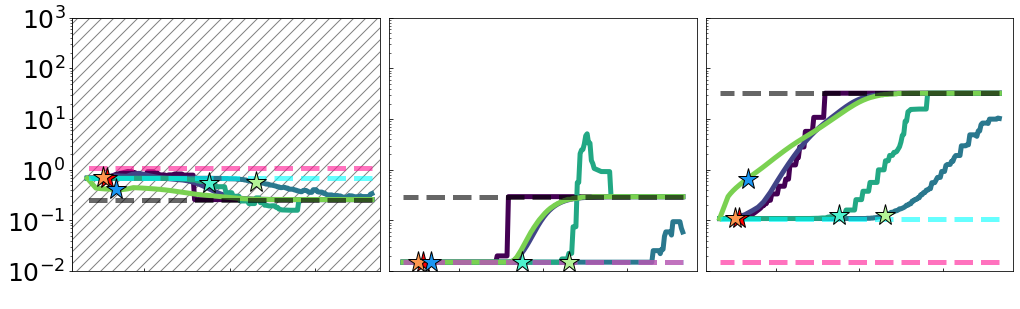

In [38]:
#GACC left out

GACC_t_none,GAGA_t_none,UUCG_t_none,GACC_v_none,GAGA_v_none,UUCG_v_none,GACC_t_bounds,GAGA_t_bounds,UUCG_t_bounds,GACC_v_bounds,GAGA_v_bounds,UUCG_v_bounds=fitting_chi2(2)

#results in GAGA_t UUCG_t and GACC_v
fig, axs = plt.subplots(1, 3,figsize=(14,4))
marker_list=['o','s','^','P','D']
cmap = plt.cm.get_cmap('viridis')
scmap = plt.cm.get_cmap('rainbow_r')

title_list=['GACC - Validation','gcGAGAgc - Training','gcUUCGgc - Training']
alpha_star_list=[0.003990341831649381,0.0026560877829466868,850.4489341802686,18.679135990207847,0.009011018251665018]
regularization_list=['L1','L2','KishSize','RelativeKishSize','RelativeEntropy']
for r,regularization in enumerate(regularization_list):
    c=cmap(r/len(regularization_list))
    m=marker_list[r]
    sc=scmap(r/len(regularization_list))
    
    error_t= np.load('./data_produced/SystemValidation_errors_%s_t.npy'%regularization,allow_pickle=True)
    error_v= np.load('./data_produced/SystemValidation_errors_%s_v.npy'%regularization,allow_pickle=True)
    GAGA_components=np.array(error_t[2])[:,2][::-1]
    UUCG_components=np.array(error_t[3])[:,2]#::-1]
    #only extract every first elem for the training error and every second elem for validation error
    UUCG_components_t=UUCG_components[0::2][::-1]
    UUCG_components_v=UUCG_components[1::2][::-1]
    #print(UUCG_components_t.shape,UUCG_components_v.shape)
    GACC_noes_components=np.array(error_v[4])[:,2][::-1]
    GACC_unoes_components=np.array(error_v[5])[:,2][::-1]
    GACC_sugar_components=np.array(error_v[6])[:,2][::-1]
    GACC_bck1_components=np.array(error_v[7])[:,2][::-1]
    GACC_bck2_components=np.array(error_v[8])[:,2][::-1]
    tot_components1=np.sum([GACC_noes_components,
GACC_unoes_components,
GACC_sugar_components,
GACC_bck1_components,
GACC_bck2_components],axis=0)
    tot_components2=np.sum([GAGA_components],axis=0)
    tot_components3=np.sum([UUCG_components_t],axis=0)
    
    
    comp_p=[tot_components1,tot_components2,tot_components3]
    for p,ax in enumerate(fig.get_axes()):
    
        if p==0:
            #ax.set_ylabel('$ \chi ^2 $',fontsize=21)
            rec2 = plt.Rectangle((0.0003,1e-2),19500000,1000,facecolor="white", 
                     edgecolor="grey", hatch=r"//")
            ax.add_patch(rec2)
            ax.set_xlim(0.0003,19500000)

        #ax.set_title(title_list[p],fontsize=12)
        ax.plot(error_t[11]+0.001,comp_p[p]+0.015,linewidth=5, color=c)#, marker=m)
        
        alpha_list=error_t[11]
        ndx=np.where(alpha_list==find_nearest(alpha_list,alpha_star_list[r]))[0][0]
        ax.plot(alpha_list[ndx]+0.001,comp_p[p][ndx]+0.015,linewidth=5, marker='*', markersize=22, markerfacecolor=sc, markeredgecolor='black', zorder=20)
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        #ax.set_xlabel('Hyperparameter',fontsize=12)
        ax.set_ylim(1e-2,1e3)
        ax.tick_params(axis="x",which='both',direction="in",labelcolor='white')
        ax.tick_params(axis="y",labelsize=25)#21) 
        ax.tick_params(axis="x",labelsize=25)#21) 
        if p > 0:
            ax.tick_params(axis="y",which='both',direction="in",labelcolor='white',labelsize=1)
        

#GACC_t_none GAGA_t_none UUCG_t_none GACC_t_bounds GAGA_t_bounds UUCG_t_bounds
nobounds_chi2=[GACC_v_none,GAGA_t_none,UUCG_t_none]
bounds_chi2=[GACC_v_bounds,GAGA_t_bounds,UUCG_t_bounds]
ref_chi2=[np.sum(ref_error_v[2][1:-2]),ref_error_t[2][-2],ref_error_t[2][-1]]
for p,ax in enumerate(fig.get_axes()):        
    orig_err=np.zeros(len(error_t[11]))
    orig_err+=ref_chi2[p]
    ax.plot(error_t[11][::-1]+0.001,orig_err+0.015, '--',linewidth=5,color='black', alpha=0.6, label='reference')

    noreg_arr_err=np.zeros(len(error_t[11]))
    noreg_arr_err+=bounds_chi2[p]
    ax.plot(error_t[11][::-1]+0.001,noreg_arr_err+0.015, '--',linewidth=5,color='cyan', alpha=0.6, label='None, bounds')
    #ax.legend() 
    
    noreg_arr_err=np.zeros(len(error_t[11]))
    noreg_arr_err+=nobounds_chi2[p]
    ax.plot(error_t[11][::-1]+0.001,noreg_arr_err+0.015, '--',linewidth=5,color='deeppink', alpha=0.6, label='None, no bounds')
     

#plt.show()
plt.tight_layout(pad=0.1)

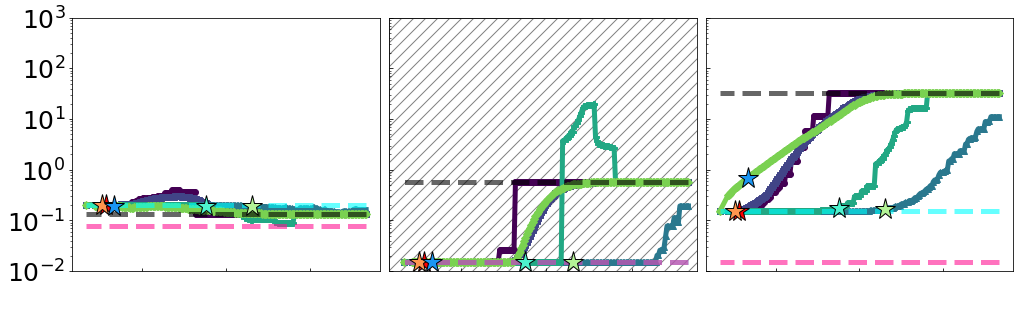

In [39]:
#GAGA left out

GACC_t_none,GAGA_t_none,UUCG_t_none,GACC_v_none,GAGA_v_none,UUCG_v_none,GACC_t_bounds,GAGA_t_bounds,UUCG_t_bounds,GACC_v_bounds,GAGA_v_bounds,UUCG_v_bounds=fitting_chi2(0)

#results in GAGA_v UUCG_t and GACC_t
fig, axs = plt.subplots(1, 3,figsize=(14,4))
marker_list=['o','s','^','P','D']
cmap = plt.cm.get_cmap('viridis')
scmap = plt.cm.get_cmap('rainbow_r')

title_list=['GACC - Training ','gcGAGAgc - Validation','gcUUCGgc - Training']
alpha_star_list=[0.003990341831649381,0.0026560877829466868,850.4489341802686,18.679135990207847,0.009011018251665018]
regularization_list=['L1','L2','KishSize','RelativeKishSize','RelativeEntropy']
for r,regularization in enumerate(regularization_list):
    c=cmap(r/len(regularization_list))
    m=marker_list[r]
    sc=scmap(r/len(regularization_list))
    
    error_t= np.load('./data_produced/SystemValidation_errors_%s_t.npy'%regularization,allow_pickle=True)
    error_v= np.load('./data_produced/SystemValidation_errors_%s_v.npy'%regularization,allow_pickle=True)
    GAGA_components=np.array(error_v[2])[:,0][::-1]
    UUCG_components=np.array(error_t[3])[:,0]#::-1]
    #only extract every first elem for the training error and every second elem for validation error
    UUCG_components_t=UUCG_components[0::2][::-1]
    UUCG_components_v=UUCG_components[1::2][::-1]
    #print(UUCG_components_t.shape,UUCG_components_v.shape)
    GACC_noes_components=np.array(error_t[4])[:,0][::-1]
    GACC_unoes_components=np.array(error_t[5])[:,0][::-1]
    GACC_sugar_components=np.array(error_t[6])[:,0][::-1]
    GACC_bck1_components=np.array(error_t[7])[:,0][::-1]
    GACC_bck2_components=np.array(error_t[8])[:,0][::-1]
    tot_components1=np.sum([GACC_noes_components,
GACC_unoes_components,
GACC_sugar_components,
GACC_bck1_components,
GACC_bck2_components],axis=0)
    tot_components2=np.sum([GAGA_components],axis=0)
    tot_components3=np.sum([UUCG_components_t],axis=0)
    
    
    comp_p=[tot_components1,tot_components2,tot_components3]
    for p,ax in enumerate(fig.get_axes()):
    
        #if p==0:
            #ax.set_ylabel('$ \chi ^2 $',fontsize=21)
        if p==1:    
            rec2 = plt.Rectangle((0.0003,1e-2),19500000,1000,facecolor="white", 
                     edgecolor="grey", hatch=r"//")
            ax.add_patch(rec2)
            ax.set_xlim(0.0003,19500000)
            
        #ax.set_title(title_list[p],fontsize=12)
        ax.plot(error_t[11]+0.001,comp_p[p]+0.015,linewidth=5, color=c, marker=m)
        
        alpha_list=error_t[11]
        ndx=np.where(alpha_list==find_nearest(alpha_list,alpha_star_list[r]))[0][0]
        ax.plot(alpha_list[ndx]+0.001,comp_p[p][ndx]+0.015,linewidth=5, marker='*', markersize=22, markerfacecolor=sc, markeredgecolor='black', zorder=20)
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        #ax.set_xlabel('Hyperparameter',fontsize=12)
        ax.set_ylim(1e-2,1e3)
        ax.tick_params(axis="x",which='both',direction="in",labelcolor='white')
        ax.tick_params(axis="y",labelsize=25) 
        ax.tick_params(axis="x",labelsize=25) 
        if p > 0:
            ax.tick_params(axis="y",which='both',direction="in",labelcolor='white',labelsize=1)

#GACC_t_none GAGA_t_none UUCG_t_none GACC_t_bounds GAGA_t_bounds UUCG_t_bounds
nobounds_chi2=[GACC_t_none,GAGA_v_none,UUCG_t_none]
bounds_chi2=[GACC_t_bounds,GAGA_v_bounds,UUCG_t_bounds]
ref_chi2=[np.sum(ref_error_t[0][1:-2]),ref_error_v[0][-2],ref_error_t[0][-1]]
for p,ax in enumerate(fig.get_axes()):        
    orig_err=np.zeros(len(error_t[11]))
    orig_err+=ref_chi2[p]
    ax.plot(error_t[11][::-1]+0.001,orig_err+0.015, '--',linewidth=5,color='black', alpha=0.6, label='reference')

    noreg_arr_err=np.zeros(len(error_t[11]))
    noreg_arr_err+=bounds_chi2[p]
    ax.plot(error_t[11][::-1]+0.001,noreg_arr_err+0.015, '--',linewidth=5,color='cyan', alpha=0.6, label='None, bounds')
    #ax.legend() 
    
    noreg_arr_err=np.zeros(len(error_t[11]))
    noreg_arr_err+=nobounds_chi2[p]
    ax.plot(error_t[11][::-1]+0.001,noreg_arr_err+0.015, '--',linewidth=5,color='deeppink', alpha=0.6, label='None, no bounds')
    
    
#plt.show()
plt.tight_layout(pad=0.1)

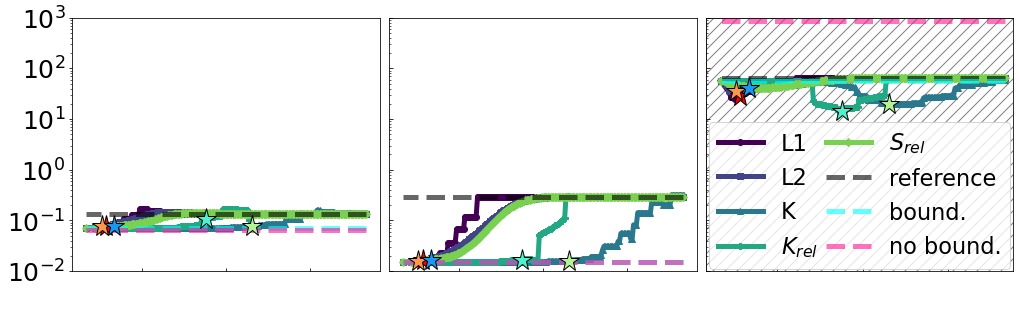

In [40]:
#UUCG left out
GACC_t_none,GAGA_t_none,UUCG_t_none,GACC_v_none,GAGA_v_none,UUCG_v_none,GACC_t_bounds,GAGA_t_bounds,UUCG_t_bounds,GACC_v_bounds,GAGA_v_bounds,UUCG_v_bounds=fitting_chi2(1)

#results in GAGA_t UUCG_v and GACC_t
fig, axs = plt.subplots(1, 3,figsize=(14,4))
marker_list=['o','s','^','P','D']
cmap = plt.cm.get_cmap('viridis')
scmap = plt.cm.get_cmap('rainbow_r')

title_list=['GACC - Training','gcGAGAgc - Training','gcUUCGgc - Validation']
alpha_star_list=[0.003990341831649381,0.0026560877829466868,850.4489341802686,18.679135990207847,0.009011018251665018]
regularization_list=['L1','L2','KishSize','RelativeKishSize','RelativeEntropy']
short_reg=['L1','L2','K','$K_{rel}$','$S_{rel}$']
for r,regularization in enumerate(regularization_list):
    c=cmap(r/len(regularization_list))
    m=marker_list[r]
    sc=scmap(r/len(regularization_list))
    
    error_t= np.load('./data_produced/SystemValidation_errors_%s_t.npy'%regularization,allow_pickle=True)
    error_v= np.load('./data_produced/SystemValidation_errors_%s_v.npy'%regularization,allow_pickle=True)
    GAGA_components=np.array(error_t[2])[:,1][::-1]
    UUCG_components=np.array(error_t[3])[:,1]#::-1]
    #only extract every first elem for the training error and every second elem for validation error
    UUCG_components_t=UUCG_components[0::2][::-1]
    UUCG_components_v=UUCG_components[1::2][::-1]
    #print(UUCG_components_t.shape,UUCG_components_v.shape)
    GACC_noes_components=np.array(error_t[4])[:,1][::-1]
    GACC_unoes_components=np.array(error_t[5])[:,1][::-1]
    GACC_sugar_components=np.array(error_t[6])[:,1][::-1]
    GACC_bck1_components=np.array(error_t[7])[:,1][::-1]
    GACC_bck2_components=np.array(error_t[8])[:,1][::-1]
    tot_components1=np.sum([GACC_noes_components,
GACC_unoes_components,
GACC_sugar_components,
GACC_bck1_components,
GACC_bck2_components],axis=0)
    tot_components2=np.sum([GAGA_components],axis=0)
    tot_components3=np.sum([UUCG_components_v],axis=0)
    
    
    comp_p=[tot_components1,tot_components2,tot_components3]
    for p,ax in enumerate(fig.get_axes()):
    
        #if p==0:
            #ax.set_ylabel('$ \chi ^2 $',fontsize=21)
            
        if p==2:    
            rec2 = plt.Rectangle((0.0003,1e-2),19500000,1000,facecolor="white", 
                     edgecolor="grey", hatch=r"//")
            ax.add_patch(rec2)
            ax.set_xlim(0.0003,19500000)
            
            
        #ax.set_title(title_list[p],fontsize=12)
        ax.plot(error_t[11]+0.001,comp_p[p]+0.015,linewidth=5, color=c, marker=m, label='%s'%short_reg[r])
        
        alpha_list=error_t[11]
        ndx=np.where(alpha_list==find_nearest(alpha_list,alpha_star_list[r]))[0][0]
        ax.plot(alpha_list[ndx]+0.001,comp_p[p][ndx]+0.015,linewidth=5, marker='*', markersize=22, markerfacecolor=sc, markeredgecolor='black', zorder=20)
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        #ax.set_xlabel('Hyperparameter',fontsize=21)
        ax.set_ylim(1e-2,1e3)
        ax.tick_params(axis="x",which='both',direction="in",labelcolor='white')
        ax.tick_params(axis="y",labelsize=25) 
        ax.tick_params(axis="x",labelsize=25)  
        if p > 0:
            ax.tick_params(axis="y",which='both',direction="in",labelcolor='white',labelsize=1)

#GACC_t_none GAGA_t_none UUCG_t_none GACC_t_bounds GAGA_t_bounds UUCG_t_bounds
nobounds_chi2=[GACC_t_none,GAGA_t_none,UUCG_v_none]
bounds_chi2=[GACC_t_bounds,GAGA_t_bounds,UUCG_v_bounds]
ref_chi2=[np.sum(ref_error_t[1][1:-2]),ref_error_t[1][-2],ref_error_v[1][-1]]
for p,ax in enumerate(fig.get_axes()):        
    orig_err=np.zeros(len(error_t[11]))
    orig_err+=ref_chi2[p]
    ax.plot(error_t[11][::-1]+0.001,orig_err+0.015, '--',linewidth=5,color='black', alpha=0.6, label='reference')

    noreg_arr_err=np.zeros(len(error_t[11]))
    noreg_arr_err+=bounds_chi2[p]
    ax.plot(error_t[11][::-1]+0.001,noreg_arr_err+0.015, '--',linewidth=5,color='cyan', alpha=0.6, label='bound.')
    #ax.legend() 
    
    noreg_arr_err=np.zeros(len(error_t[11]))
    noreg_arr_err+=nobounds_chi2[p]
    ax.plot(error_t[11][::-1]+0.001,noreg_arr_err+0.015, '--',linewidth=5,color='deeppink', alpha=0.6, label='no bound.')
    
    if p==2:
        #ax.legend(loc='lower right', fontsize=12)
        #ax.legend(bbox_to_anchor=(0.01, -0.01), loc='lower left', borderaxespad=0.)
        plt.legend(bbox_to_anchor=(0.01, 0.01, 0.98, 1), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0., fontsize=22.5)
    

    
#plt.show()
plt.tight_layout(pad=0.1)

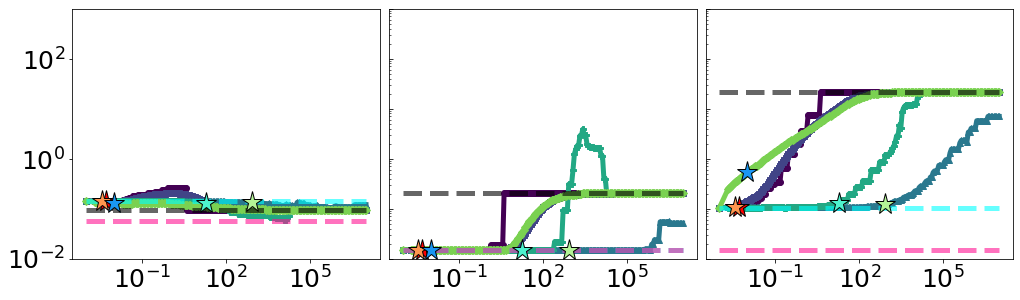

In [41]:
#plot the components of chi2 for GACC GAGA UUCG

fig, axs = plt.subplots(1, 3,figsize=(14,4))
marker_list=['o','s','^','P','D']
cmap = plt.cm.get_cmap('viridis')
scmap = plt.cm.get_cmap('rainbow_r')
regularization_list=['L1','L2','KishSize','RelativeKishSize','RelativeEntropy']
alpha_star_list=[0.003990341831649381,0.0026560877829466868,850.4489341802686,18.679135990207847,0.009011018251665018]

for r,regularization in enumerate(regularization_list):
    c=cmap(r/len(regularization_list))
    m=marker_list[r]
    sc=scmap(r/len(regularization_list))
    
    
    data=np.load('./data_produced/HScan_AllData_bounds_chi2components_%s.npy' %(regularization),allow_pickle=True)
    
    GAGA_components=np.array(data[1])
    UUCG_components=np.array(data[2])
    GACC_noes_components=np.array(data[3])
    GACC_unoes_components=np.array(data[4])
    GACC_sugar_components=np.array(data[5])
    GACC_bck1_components=np.array(data[6])
    GACC_bck2_components=np.array(data[7])
    tot_components1=np.sum([GACC_noes_components,
    GACC_unoes_components,
    GACC_sugar_components,
    GACC_bck1_components,
    GACC_bck2_components],axis=0)
    tot_components2=np.sum([GAGA_components],axis=0)
    tot_components3=np.sum([UUCG_components],axis=0)
    
    
    comp_p=[tot_components1,tot_components2,tot_components3]
    
    
    
    for p,ax in enumerate(fig.get_axes()):
    
        #if p==0:
            #ax.set_ylabel('$ \chi ^2 $',fontsize=12)
        #ax.set_title(title_list[p],fontsize=12)
        
        alpha_list=data[0]
        
        ax.plot(alpha_list+0.001,comp_p[p]+0.015,linewidth=5, color=c, marker=m)
        ndx=np.where(alpha_list==find_nearest(alpha_list,alpha_star_list[r]))[0][0]
        ax.plot(alpha_list[ndx]+0.001,comp_p[p][ndx]+0.015,linewidth=5, marker='*', markersize=22, markerfacecolor=sc, markeredgecolor='black', zorder=20)
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        #ax.set_xlabel('Hyperparameter',fontsize=12)
        ax.set_ylim(1e-2,1e3)
        ax.tick_params(axis="both",labelsize=25) 
        if p > 0:
            ax.tick_params(axis="y",which='both',direction="in",labelcolor='white',labelsize=1)

#reference 
ref_error= np.load('./data_produced/ReferenceErrors_FullData.npy',allow_pickle=True)
#full min no reg bounds
error_noreg_bounds= np.load('./data_produced/SingleMinimization_bounds_errors_None.npy',allow_pickle=True)
#full min no reg no bounds
error_noreg_nobounds= np.load('./data_produced/SingleMinimization_errors_None.npy',allow_pickle=True)


singlemin_bounds_error=[np.sum(error_noreg_bounds[4:9]),error_noreg_bounds[2][0],error_noreg_bounds[3][0]]
singlemin_nobounds_error=[np.sum(error_noreg_nobounds[4:9]),error_noreg_nobounds[2][0],error_noreg_nobounds[3][0]]
ref_chi2=[ref_error[2][0]/3,ref_error[0][0]/3,ref_error[1][0]/3]
for p,ax in enumerate(fig.get_axes()):        
    orig_err=np.zeros(len(alpha_list))
    orig_err+=ref_chi2[p]
    ax.plot(alpha_list+0.001,orig_err+0.015, '--',linewidth=5,color='black', alpha=0.6, label='reference')
    
    noreg_arr_err=np.zeros(len(alpha_list))
    noreg_arr_err+=singlemin_bounds_error[p]
    ax.plot(alpha_list+0.001,noreg_arr_err+0.015, '--',linewidth=5,color='cyan', alpha=0.6, label='None, bounds')
    
    noreg_arr_err=np.zeros(len(alpha_list))
    noreg_arr_err+=singlemin_nobounds_error[p]
    ax.plot(alpha_list+0.001,noreg_arr_err+0.015, '--',linewidth=5,color='deeppink', alpha=0.6, label='None, no bounds')
    
    
#plt.show()
plt.tight_layout(pad=0.1)

In [42]:
#plot the parameters

In [43]:
def plot_param(data,b_flag):
    cmap = plt.cm.get_cmap('gist_gray')

    for l,lambdas in enumerate(data):
        newlambdas = data[l].reshape(-1,12)
        l=newlambdas[0].reshape(2,6)
        #l=newlambdas[0].reshape(1,12)
        #plt.matshow(l,cmap='seismic_r',vmin=-np.max(abs(l)),vmax=np.max(abs(l)))
        #print(l)
        l=np.around(l, decimals=1, out=None)
        #print(l)
        plt.matshow(l,cmap='seismic_r',vmin=-0.5,vmax=0.5)
        for (i, j), z in np.ndenumerate(l):
            if z < 0.5:
                if abs(z) <0.1:
                    c='black'
                    z=abs(z)
                else:
                    c='white'
            elif b_flag==True:
                c='black'
                z=abs(z)
            else:
                c='black'
                z=abs(z)
                if abs(z) > 0.1:
                    c='white'                    
            plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=35, color=c)#cmap((z)/len(newlambdas)))
        plt.axis('off')
        #plt.show()

In [44]:
#add ghbfix ontop of all the parameters
#in kcal/mol
gHBfix=[]
for i in range(12):
    gHBfix.append(0.0)

gHBfix[1]=1.0
gHBfix[6]=-0.5
gHBfix[8]=-0.5
gHBfix=np.array(gHBfix)   

#visualize starting parameters and parameters with no reg when leaving out the indiv systems

#select 3 intermediate alpha values (the middle one is the alpha* from the CVObs), also there, show the param

In [45]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [46]:
def reorder(input_array):
    
    temp=input_array
    
    input_array=np.array([temp[1],temp[4],temp[3],temp[5],temp[0],temp[2],temp[7],temp[10],temp[9],temp[11],temp[6],temp[8]])
    
    return input_array

In [47]:
alpha_star_list=[0.003990341831649381,0.0026560877829466868,850.4489341802686,18.679135990207847,0.009011018251665018]
regularization_list=['L1','L2','KishSize','RelativeKishSize','RelativeEntropy']

GACC left out
Original
No regularization
L1
L2
KishSize
RelativeKishSize
RelativeEntropy


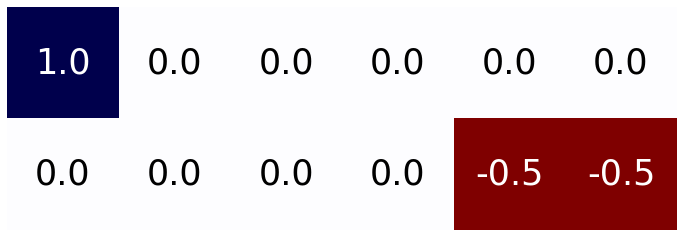

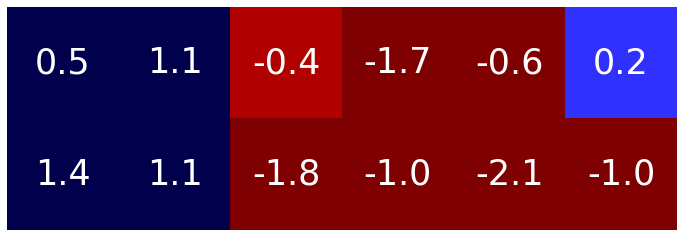

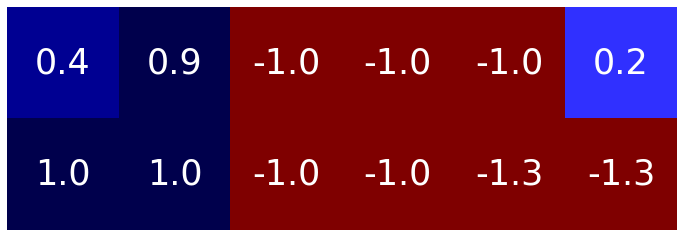

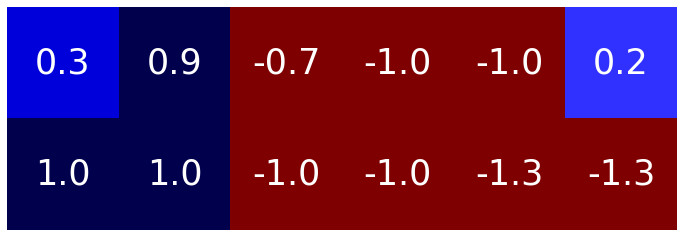

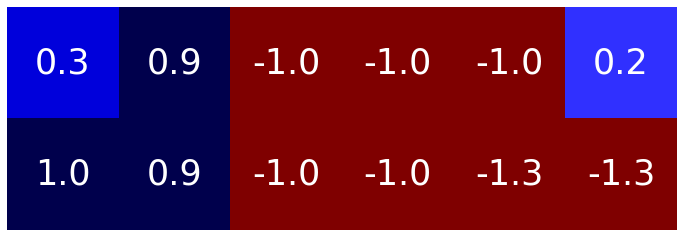

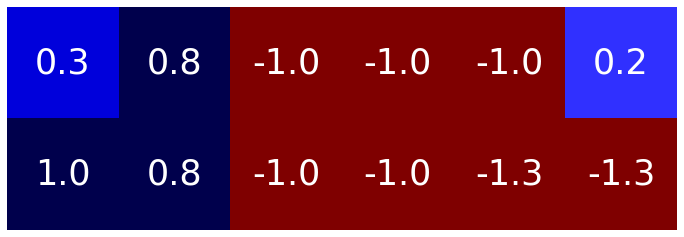

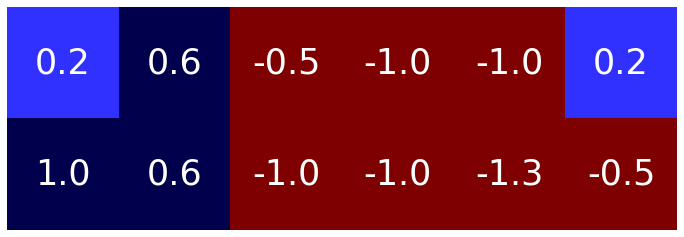

In [48]:
print('GACC left out')

print('Original')
plot_param([reorder(gHBfix)],False)

print('No regularization')
lambdas = np.load('./data_produced/SystemValidation_Lambdas_None.npy',allow_pickle=True)
lambdas[2]+=gHBfix
lambdas[2]/=1.666666666666666
plot_param([reorder(lambdas[2])],False)

for r,regularization in enumerate(regularization_list):
    print(regularization)
    lambdas=np.load("./data_produced/SystemValidation_Lambdas_%s.npy"%regularization)
    alpha_list = np.geomspace(10**-3, 10**7, 200) 
    alpha_list = np.insert(alpha_list, 0, 0.0, axis=0)
    alpha_list=alpha_list[::-1]
    
    ndx=np.where(alpha_list==find_nearest(alpha_list,alpha_star_list[r]))[0][0]
    lambdas=(lambdas[ndx,2,:]+gHBfix)/1.666666666666666
    plot_param([reorder(lambdas)],False)

GAGA left out
Original
No regularization
L1
L2
KishSize
RelativeKishSize
RelativeEntropy


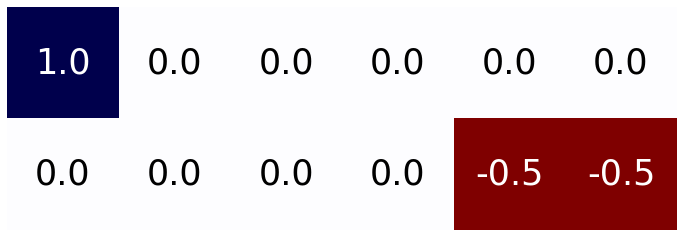

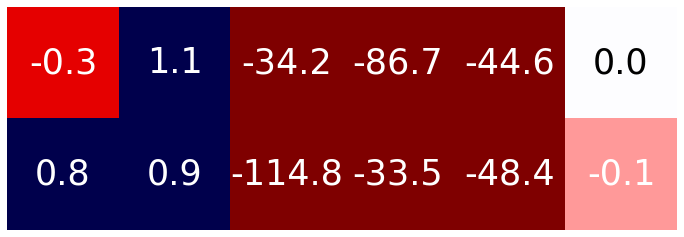

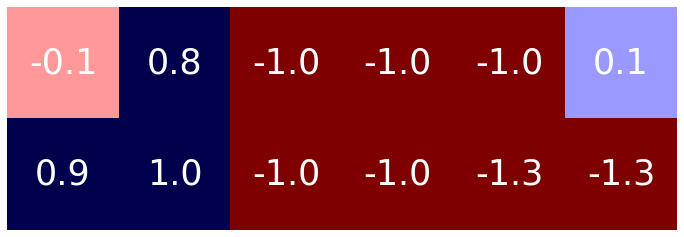

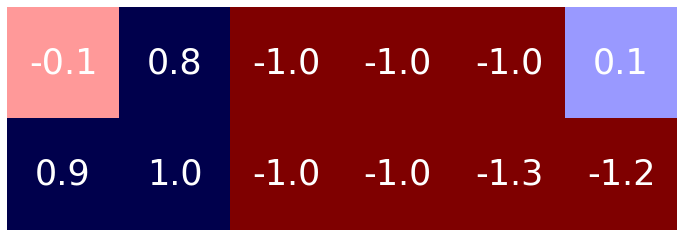

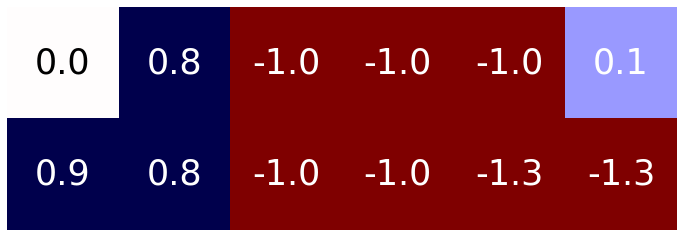

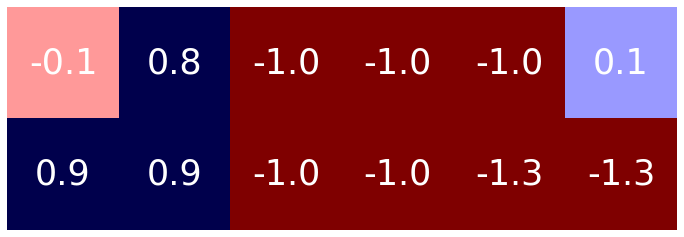

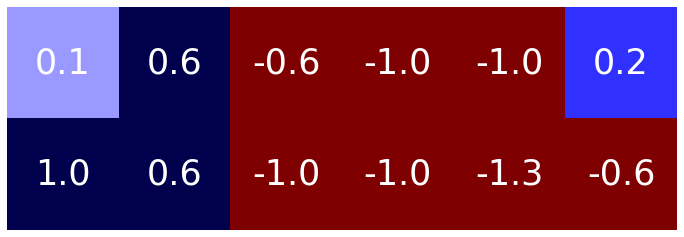

In [49]:
print('GAGA left out')

print('Original')
plot_param([reorder(gHBfix)],False)

print('No regularization')
lambdas = np.load('./data_produced/SystemValidation_Lambdas_None.npy',allow_pickle=True)
lambdas[0]+=gHBfix
lambdas[0]/=1.666666666666666
plot_param([reorder(lambdas[0])],False)

for r,regularization in enumerate(regularization_list):
    print(regularization)
    lambdas=np.load("./data_produced/SystemValidation_Lambdas_%s.npy"%regularization)
    alpha_list = np.geomspace(10**-3, 10**7, 200) 
    alpha_list = np.insert(alpha_list, 0, 0.0, axis=0)
    alpha_list=alpha_list[::-1]
    
    ndx=np.where(alpha_list==find_nearest(alpha_list,alpha_star_list[r]))[0][0]
    lambdas=(lambdas[ndx,0,:]+gHBfix)/1.666666666666666
    plot_param([reorder(lambdas)],False)

UUCG left out
Original
No regularization
L1
L2
KishSize
RelativeKishSize
RelativeEntropy


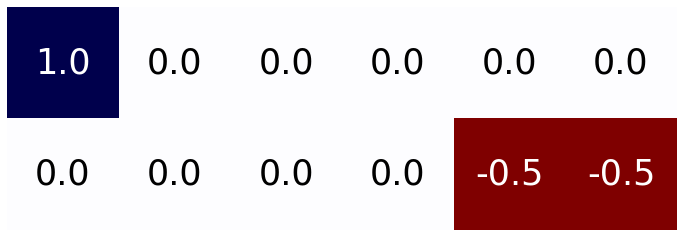

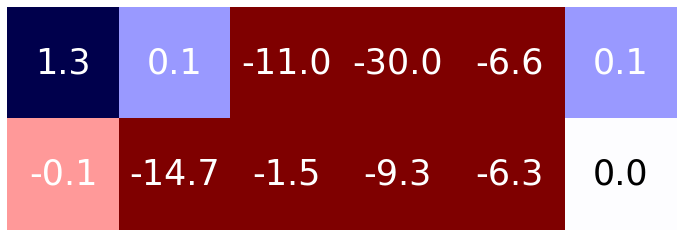

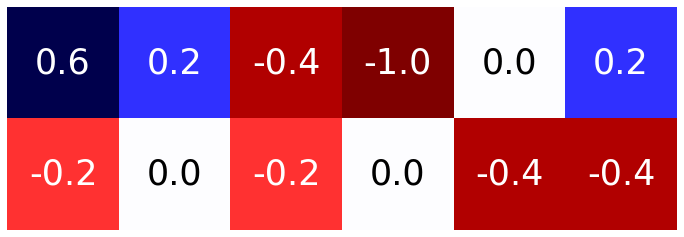

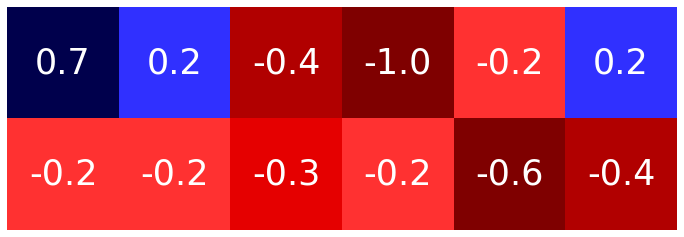

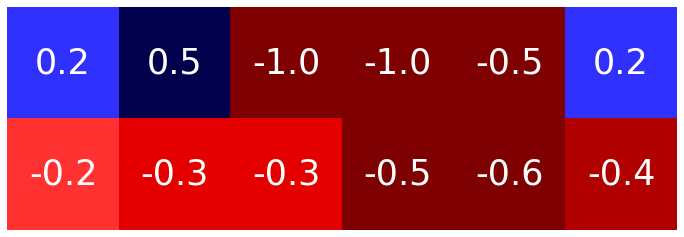

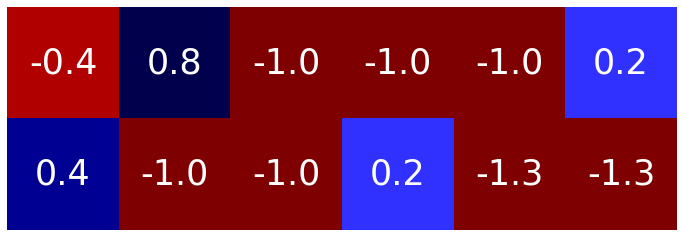

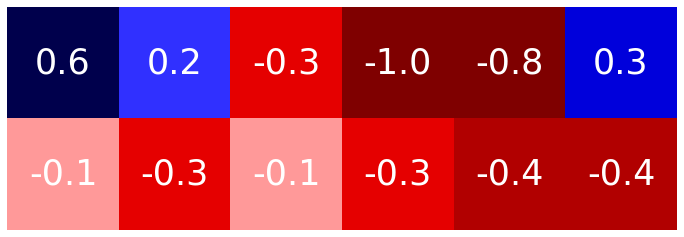

In [50]:
print('UUCG left out')

print('Original')
plot_param([reorder(gHBfix)],False)

print('No regularization')
lambdas = np.load('./data_produced/SystemValidation_Lambdas_None.npy',allow_pickle=True)
lambdas[1]+=gHBfix
lambdas[1]/=1.666666666666666
plot_param([reorder(lambdas[1])],False)
for r,regularization in enumerate(regularization_list):
    print(regularization)
    lambdas=np.load("./data_produced/SystemValidation_Lambdas_%s.npy"%regularization)
    alpha_list = np.geomspace(10**-3, 10**7, 200) 
    alpha_list = np.insert(alpha_list, 0, 0.0, axis=0)
    alpha_list=alpha_list[::-1]
    
    ndx=np.where(alpha_list==find_nearest(alpha_list,alpha_star_list[r]))[0][0]
    lambdas=(lambdas[ndx,1,:]+gHBfix)/1.666666666666666
    plot_param([reorder(lambdas)],False)

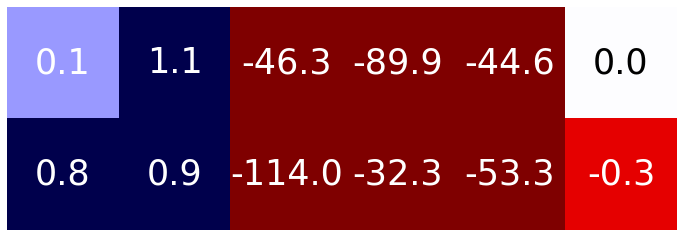

In [52]:
lambdas = np.load('./data_produced/SingleMinimization_Lambdas_None.npy',allow_pickle=True)
#in kcal/mol
data=lambdas /1.666666666666666
data=data+gHBfix
cmap = plt.cm.get_cmap('gist_gray')

for l,lambdas in enumerate(data):
    newlambdas = reorder(data[l]).reshape(-1,12)
    l=newlambdas[0].reshape(2,6)
    #plt.matshow(l,cmap='seismic_r',vmin=-np.max(abs(l)),vmax=np.max(abs(l)))
    l=np.around(l, decimals=1, out=None)
    plt.matshow(l,cmap='seismic_r',vmin=-0.5,vmax=0.5)
    for (i, j), z in np.ndenumerate(l):
        c='white' #'black' #'white'
        
        if abs(z) < 0.1:           
            c='black'
        plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=35, color=c)#cmap((z)/len(newlambdas)))
    plt.axis('off')
    plt.show()

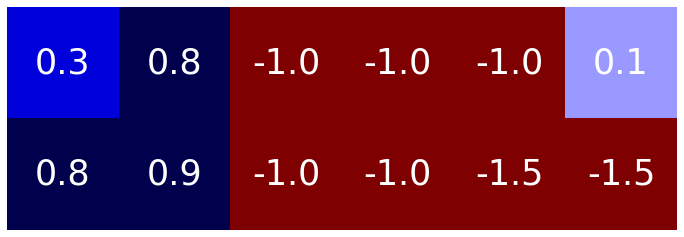

In [54]:
lambdas = np.load('./data_produced/parameters.npy',allow_pickle=True)

#in kcal/mol
data=lambdas /1.666666666666666
data=data+gHBfix
cmap = plt.cm.get_cmap('gist_gray')

for l,lambdas in enumerate(data):
    newlambdas = reorder(data[l]).reshape(-1,12)
    l=newlambdas[0].reshape(2,6)
    #plt.matshow(l,cmap='seismic_r',vmin=-np.max(abs(l)),vmax=np.max(abs(l)))
    l=np.around(l, decimals=1, out=None)
    plt.matshow(l,cmap='seismic_r',vmin=-0.5,vmax=0.5)
    for (i, j), z in np.ndenumerate(l):
        c='white' #'black' #'white'
        
        if abs(z) < 0.1:           
            c='black'
        plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=35, color=c)#cmap((z)/len(newlambdas)))
    plt.axis('off')
    plt.show()